# Topical Expert Model

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import operator
import os
print(os.getcwd())
print(os.listdir('/Users/Brandon/Yelp Dataset/dataset'))
import json
import glob
from datetime import datetime
from pandas import HDFStore,DataFrame
import operator
import pylab as pl
import json

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib

/Users/Brandon/Yelp Dataset/Yelp-FA17/local-elites/workspace
['.DS_Store', 'business.json', 'checkin.json', 'photos.json', 'review.json', 'review5000.json', 'tip.json', 'user.json', 'user5000.json']


In [2]:
#Copied from Kenta
def load_json_to_df(datapass):
    '''
    Load the json file and parse the file to pandas dataframe format
    
    Input:
        datapass(str) : directory to the json file
    Output:
        df(dataframe) : pandas dataframe object
    '''
    
    data = [] 
    with open(datapass) as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

LOAD THE DATA

In [3]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/review.json"
review = load_json_to_df(import_file)
review = review.drop('text', 1)

CPU times: user 1min 7s, sys: 19.4 s, total: 1min 26s
Wall time: 1min 35s


In [4]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/business.json"
business = load_json_to_df(import_file)

CPU times: user 4.75 s, sys: 317 ms, total: 5.07 s
Wall time: 5.13 s


In [5]:
%%time
import_file = "/Users/Brandon/Yelp Dataset/dataset/user.json"
user = load_json_to_df(import_file)

CPU times: user 46.1 s, sys: 4.26 s, total: 50.3 s
Wall time: 51.8 s


Sort by category

In [6]:
def categoryFind(df, cat):
    return [cat in i for i in df['categories']]

def category_counts(df):
    all_cats = []
    for i in df['categories']:
        for j in i:
            all_cats.append(j)
    categories = set(all_cats)
    category_counts = {}
    for cat in categories:
        category_counts[cat] = all_cats.count(cat)
    return len(categories), category_counts

def top_categories(counts, n):
    top_categories = sorted(counts.keys(), key=(lambda k: counts[k]),reverse=True)[:n]
    return top_categories

In [7]:
num_cats, cat_counts = category_counts(business)
top_cats = top_categories(cat_counts, 100)
display(top_cats)

['Restaurants',
 'Shopping',
 'Food',
 'Beauty & Spas',
 'Home Services',
 'Health & Medical',
 'Nightlife',
 'Bars',
 'Automotive',
 'Local Services',
 'Event Planning & Services',
 'Active Life',
 'Fashion',
 'Sandwiches',
 'Fast Food',
 'American (Traditional)',
 'Pizza',
 'Coffee & Tea',
 'Hair Salons',
 'Hotels & Travel',
 'Arts & Entertainment',
 'Home & Garden',
 'Auto Repair',
 'Italian',
 'Burgers',
 'Doctors',
 'Breakfast & Brunch',
 'Mexican',
 'Nail Salons',
 'Professional Services',
 'American (New)',
 'Chinese',
 'Real Estate',
 'Specialty Food',
 'Fitness & Instruction',
 'Pets',
 'Grocery',
 'Bakeries',
 'Cafes',
 'Hair Removal',
 'Dentists',
 'Hotels',
 'Desserts',
 'Skin Care',
 "Women's Clothing",
 'Education',
 'Japanese',
 'Ice Cream & Frozen Yogurt',
 'Pet Services',
 'Day Spas',
 'Massage',
 'General Dentistry',
 'Financial Services',
 'Pubs',
 'Chicken Wings',
 'Seafood',
 'Contractors',
 'Salad',
 'Gyms',
 'Sushi Bars',
 'Sports Bars',
 'Apartments',
 'Caterers

In [8]:
%%time
businessReviews = pd.merge(review, business,on='business_id',right_index=True,sort=False)[['business_id', 'cool', 'funny', 'review_id', 'stars_x', 'useful', 'user_id', 'categories', 'review_count', 'stars_y']]
bus_rev_users = pd.merge(businessReviews, user,on='user_id',right_index=True,sort=False)[['business_id', 'cool_x', 'funny_x', 'review_id', 'stars_x', 'useful_x', 'user_id', 'categories', 'stars_y', 'average_stars', 'cool_y', 'elite', 'fans', 'friends', 'name', 'review_count_y', 'yelping_since']]

CPU times: user 43.3 s, sys: 9.32 s, total: 52.6 s
Wall time: 56 s


## Feature Extraction From Yelp Data

In [9]:
def category_choose(df, categories):
    cats = np.array([True] * len(df['categories']))
    for cat in categories:
        cats= cats & np.array(categoryFind(df,cat))
    return df[cats]

def numCategoryReviews(businessReviews):
    return businessReviews[['business_id','user_id']].groupby('user_id',as_index=False).count()

def average_star_category_rating(businessReviews):
    return businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).mean()

def std_star_category_rating(businessReviews):
    busRev = businessReviews[['user_id','stars_x']].groupby('user_id',as_index=False).agg(np.var)
    busRev['stars_x'] = busRev['stars_x'].pow(1./2)
    return busRev

def funny_useful_cool(businessReviews):
    return businessReviews[['user_id','funny','useful','cool']].groupby('user_id',as_index=False).sum()

def months_yelping(businessReviews):
    user_dates = businessReviews[['user_id','yelping_since']].drop_duplicates()
    curr_date = datetime(2017,10,17)
    uyelp_dates = [datetime.strptime(i, "%Y-%m-%d") for i in user_dates['yelping_since']]
    months_yelping = [(curr_date.year - i.year) * 12 + curr_date.month - i.month for i in uyelp_dates]
    user_dates['yelping_since'] = months_yelping
    return user_dates

def get_elite_users(df):
    temp = []
    for i in df['elite'].index.values:
        if df['elite'][i]:
            temp.append(i)
    return temp, df.loc[temp]

## Define the first feature model to be analyzed
Features: Total Reviews by User, Number of Category Reviews, Average Rating in Category, Std Dev of Ratings in Category, Funny, Useful, and Cool Votes, Number of Months since joining Yelp.

In [10]:
def feature1(df, df1, categories):
    if( not categories == "All"):
        df = category_choose(df, categories)
        df1 = category_choose(df1, categories)
    tot_reviews = df1[['user_id','review_count_y']]
    tot_reviews.columns = ['user_id','Total Reviews by User']
    catRev = numCategoryReviews(df)
    catRev.columns = ['user_id','Num Category Reviews']
    averageCat = average_star_category_rating(df)
    averageCat.columns = ['user_id','Average Rating in Category']
    stdCat = std_star_category_rating(df)
    stdCat.columns = ['user_id','Std Dev of Ratings in Category']
    fuc = funny_useful_cool(df)
    monthsYelp = months_yelping(df1)
    monthsYelp.columns = ['user_id', 'Months Yelping']
    is_elite = df1[['user_id','elite']]
    features = tot_reviews.merge(catRev,on='user_id').merge(averageCat,on='user_id').merge(stdCat,on='user_id').merge(fuc,on='user_id').merge(monthsYelp,on='user_id').merge(is_elite,on='user_id')
    features = features.drop_duplicates('user_id')
    features.index = range(len(features))
    elite_ind, elite_users = get_elite_users(features)
    expertClassifier = [0]*len(features)
    for i in elite_ind:
        expertClassifier[i]=1
    features = pd.concat([features, pd.DataFrame(expertClassifier,columns=['is_expert'])],axis=1)
    return features.fillna(0)

# Feature 2 has all of feature 1 plus the number of friends for each user
def feature2(df, df1, categories, features1 = pd.DataFrame()):
    if features1.empty:
        features1= feature1(df,df1,categories)
    
    friends = pd.DataFrame([len(i) for i in df1['friends']], columns = ['Num_Friends'])
    users = pd.DataFrame(df1['user_id'].values,columns=['user_id'])
    num_friends = pd.concat([users, friends],axis=1)
    features1= features1.merge(num_friends,on='user_id').drop_duplicates('user_id')
    features1.index = range(len(features1))
    return features1

# Unsupervised Learning
## Kmeans Cluster

In [11]:
'''Runs the model specified by the clf (classifier), and features.
Features is assumed to have an 'is_expert' column which gives comparisons to unsupervised learning'''
from sklearn.cluster import KMeans
def run_unsup_model(clf, features):
    train = features.drop('is_expert',axis=1)
    clf.fit(train)
    rf_pred = clf.predict(train)
    model_perf= {'Model_Score' : clf.score(train),
                'Predictions' : rf_pred,
                'Total_Tested' : len(rf_pred),
                'Num_Experts_Predicted' : sum(rf_pred),
                'Num_Non_Experts' : sum(1-rf_pred),
                'Cluster_Centers' : clf.cluster_centers_,
                'Cluster_Points' : clf.transform(train)} 
    return model_perf

def graph_clusters(model):
    x = model['Cluster_Points'][:,0]
    y = model['Cluster_Points'][:,1]
    labels = model['Predictions']
    plt.scatter(x, y, c=[matplotlib.cm.spectral(float(i) /10) for i in labels]);   
    plt.show()

def add_pred_column(model, features):
    return features.assign(preds=pd.Series(model['Predictions']).values)

def unsup_statistics(model, features):
    features = add_pred_column(model, features)
    return {'Num_Experts' : sum(features.is_expert),
            'Num_Experts_Predicted' : sum(features.preds),
            'Intersection' : sum(features.is_expert & features.preds)}

def kmeans_model(n_clusters, X, feature_set):
    clf_KMeans = KMeans(n_clusters=n_clusters)
    model_test = run_unsup_model(clf_KMeans, X)
    display(graph_clusters(model_test))
    display(unsup_statistics(model_test, X))
    predictions = add_pred_column(model_test, feature_set)
    return predictions

## Evaluation Model

In [12]:
from sklearn.metrics import mean_squared_error
def evaluate_category(businessReviews, categories, category_features):
    bus_revs = category_choose(businessReviews, categories)[['business_id', 'review_id', 'user_id', 'stars_x', 'stars_y',]]
    
    cat_feat = category_features[['user_id', 'preds']]
    
    bus_revs_preds = pd.merge(bus_revs, cat_feat, on='user_id',right_index=True,sort=False).sort_values('business_id')
    bus_revs_preds.index = range(len(bus_revs_preds['business_id']))
    
    topic_evaluate = pd.DataFrame(columns=[['business_id', 'expert_stars','num_experts', 'avg_exp_stars', 'user_stars','num_users', 'avg_user_stars']])
    topic_evaluate['business_id']= bus_revs_preds.drop_duplicates('business_id')['business_id']
    topic_evaluate.index = range(len(topic_evaluate['business_id']))
    
    for i in range(0, len(topic_evaluate)):
        temp_bid = topic_evaluate['business_id'][i]
        temp_bus = bus_revs_preds[bus_revs_preds.business_id.isin([temp_bid])]
        temp_experts = temp_bus[temp_bus.preds==1]
        temp_users = temp_bus[temp_bus.preds==0]
        topic_evaluate['expert_stars'][i] = temp_experts['stars_x'].sum()
        topic_evaluate['num_experts'][i] = len(temp_experts)
        topic_evaluate['avg_exp_stars'][i] = temp_experts['stars_x'].mean()
        topic_evaluate['user_stars'][i] = temp_users['stars_x'].sum()
        topic_evaluate['num_users'][i] = len(temp_users)
        topic_evaluate['avg_user_stars'][i] = temp_users['stars_x'].mean()
    return topic_evaluate

def evaluate_category_stats(cat_evals, categories, plot):
    num_bus = len(cat_evals)
    cat_evals = cat_evals.dropna()
    diffs = (cat_evals['avg_exp_stars'] - cat_evals['avg_user_stars'])
    if(plot):
        diffs.plot(kind='hist')
        plt.show()
        
        tmp1 = []
        for i in range(1,30):
            tmp1.append(len(cat_evals[cat_evals.num_experts==i]))
        pd.DataFrame(tmp1,columns=['Frequency']).plot(y='Frequency')
        plt.show()
        
    num_bus_with_experts = len(diffs)
    mean_diff = abs(diffs).mean()
    avg_user_stars = cat_evals['avg_user_stars'].mean()
    if not cat_evals['avg_exp_stars'].empty:
        MSE = mean_squared_error(cat_evals['avg_user_stars'], cat_evals['avg_exp_stars'])
        avg_expert_stars = cat_evals['avg_exp_stars'].mean() 
    else:
        MSE = np.nan
        avg_expert_stars = np.nan
    cat_dict = {'Categories': categories, 'Number of Businesses' : num_bus, 
                'Number of Businesses with Experts' : num_bus_with_experts,
                'MAE' : mean_diff, 
                'MSE' : MSE, 'Average Expert Stars' : avg_expert_stars, 
                'Average User Stars': avg_user_stars}
    return cat_dict
    
def evaluate_category_single(businessReviews, categories, category_features, plot):
    return evaluate_category_stats(evaluate_category(businessReviews, categories, category_features), categories, plot)

def evaluate_categories(businessReviews, bus_rev_users, categories, plot):
    evaluation = pd.DataFrame()
    if type(categories) == str:
        categories = [categories]
    for cat in categories:
        if type(cat) == str:
            cat = [cat]
        feature_set = feature1(businessReviews, bus_rev_users, cat)
        if feature_set.empty:
            continue
        X = feature_set.drop('user_id',axis=1).drop('elite',axis=1)
        cat_features = kmeans_model(n_clusters = 2, X=X, feature_set = feature_set)
        this_eval = evaluate_category_single(businessReviews, cat, cat_features, plot)
        display(this_eval)
        evaluation = evaluation.append(pd.DataFrame(pd.Series(this_eval)).transpose())
    return evaluation

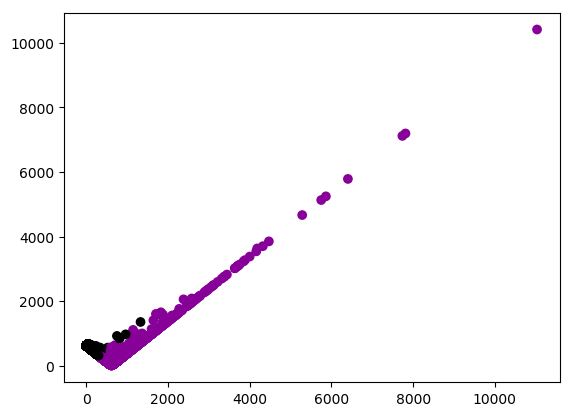

None

{'Intersection': 6536, 'Num_Experts': 28185, 'Num_Experts_Predicted': 7278}

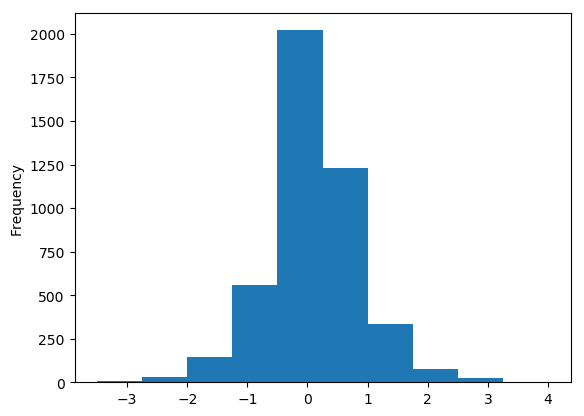

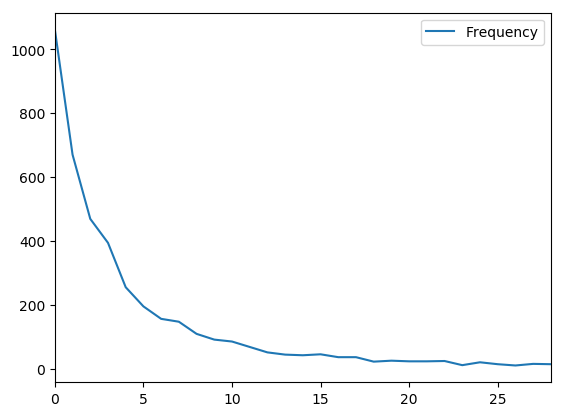

{'Average Expert Stars': 3.3971154454053201,
 'Average User Stars': 3.3186548485485972,
 'Categories': ['American (Traditional)'],
 'MAE': 0.55200537788852333,
 'MSE': 0.57727641888730308,
 'Number of Businesses': 5737,
 'Number of Businesses with Experts': 4429}

In [13]:
single_cat = evaluate_categories(businessReviews, bus_rev_users, top_cats[15], True)

In [14]:
single_cat

,Average Expert Stars,Average User Stars,Categories,MAE,MSE,Number of Businesses,Number of Businesses with Experts
0,3.39712,3.31865,[American (Traditional)],0.552005,0.577276,5737,4429


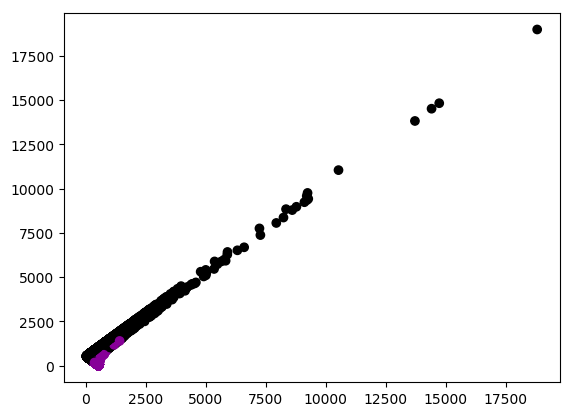

None

{'Intersection': 37901, 'Num_Experts': 50679, 'Num_Experts_Predicted': 808835}

{'Average Expert Stars': 3.462080864775734,
 'Average User Stars': 3.4766296910332497,
 'Categories': ['Restaurants'],
 'MAE': 0.59828097337937958,
 'MSE': 0.68494196631367121,
 'Number of Businesses': 51613,
 'Number of Businesses with Experts': 39058}

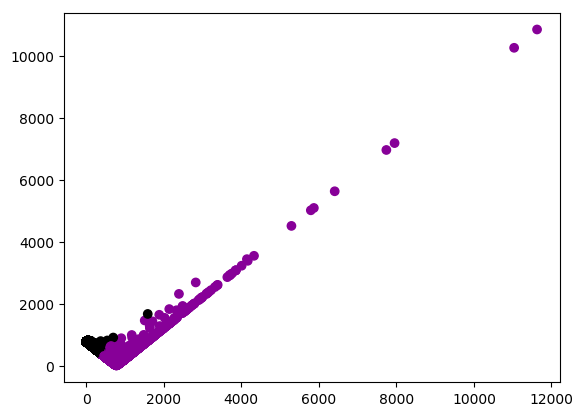

None

{'Intersection': 3293, 'Num_Experts': 15810, 'Num_Experts_Predicted': 3626}

{'Average Expert Stars': 3.7122832963527324,
 'Average User Stars': 3.5392094727507137,
 'Categories': ['Shopping'],
 'MAE': 0.7858706759205748,
 'MSE': 1.1068899767904621,
 'Number of Businesses': 24595,
 'Number of Businesses with Experts': 12018}

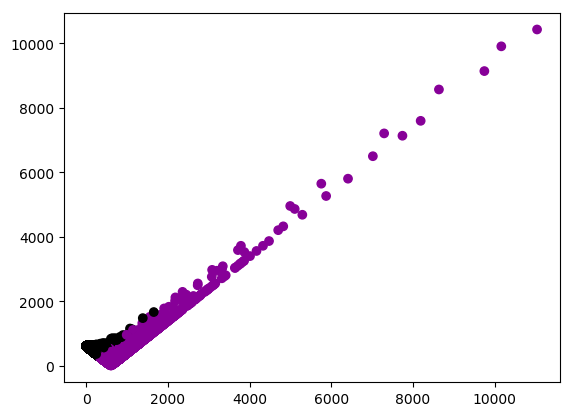

None

{'Intersection': 7815, 'Num_Experts': 33583, 'Num_Experts_Predicted': 8714}

{'Average Expert Stars': 3.6914931414860468,
 'Average User Stars': 3.6654159774855182,
 'Categories': ['Food'],
 'MAE': 0.62112384916782915,
 'MSE': 0.72751052489402612,
 'Number of Businesses': 23014,
 'Number of Businesses with Experts': 16759}

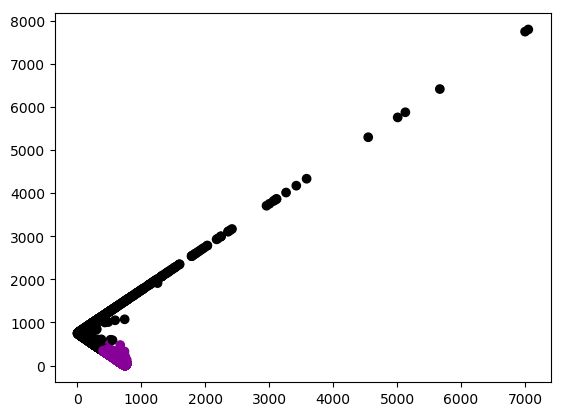

None

{'Intersection': 9945, 'Num_Experts': 12331, 'Num_Experts_Predicted': 187003}

{'Average Expert Stars': 3.7724430057583676,
 'Average User Stars': 3.8677287380497023,
 'Categories': ['Beauty & Spas'],
 'MAE': 0.7960878464038349,
 'MSE': 1.1457886143074973,
 'Number of Businesses': 15139,
 'Number of Businesses with Experts': 3798}

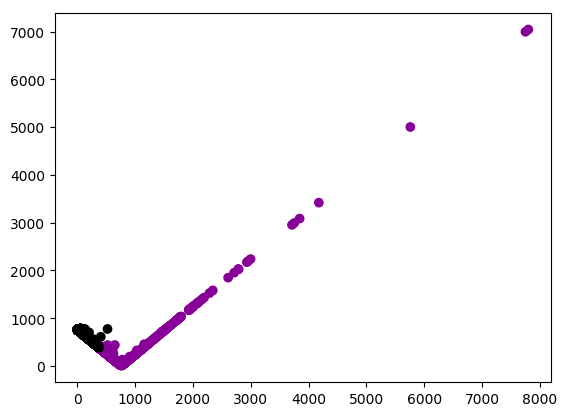

None

{'Intersection': 941, 'Num_Experts': 4971, 'Num_Experts_Predicted': 1039}

{'Average Expert Stars': 3.7386775888334771,
 'Average User Stars': 3.4619302456551404,
 'Categories': ['Home Services'],
 'MAE': 0.98101633762995144,
 'MSE': 1.7549101529932578,
 'Number of Businesses': 13202,
 'Number of Businesses with Experts': 1939}

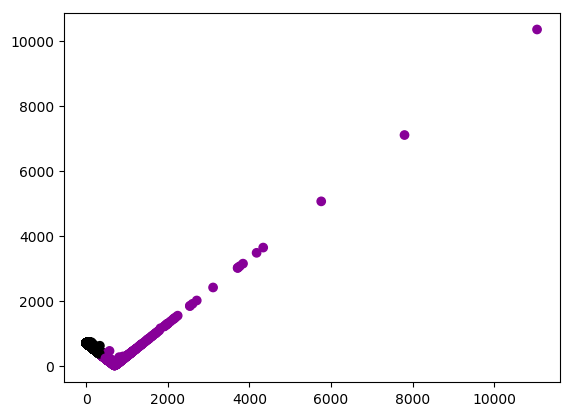

None

{'Intersection': 882, 'Num_Experts': 5358, 'Num_Experts_Predicted': 982}

{'Average Expert Stars': 3.9485339616869939,
 'Average User Stars': 3.6155370788980425,
 'Categories': ['Health & Medical'],
 'MAE': 0.95958575508715238,
 'MSE': 1.6262174441055086,
 'Number of Businesses': 12033,
 'Number of Businesses with Experts': 2595}

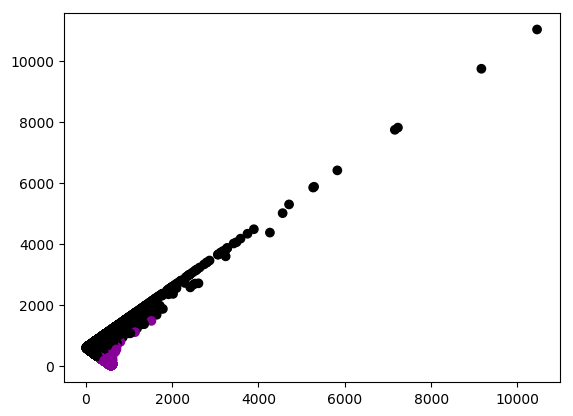

None

{'Intersection': 27453, 'Num_Experts': 36034, 'Num_Experts_Predicted': 350893}

{'Average Expert Stars': 3.5203194008345435,
 'Average User Stars': 3.5251032362980599,
 'Categories': ['Nightlife'],
 'MAE': 0.52924245581192064,
 'MSE': 0.5538236603622263,
 'Number of Businesses': 11364,
 'Number of Businesses with Experts': 8664}

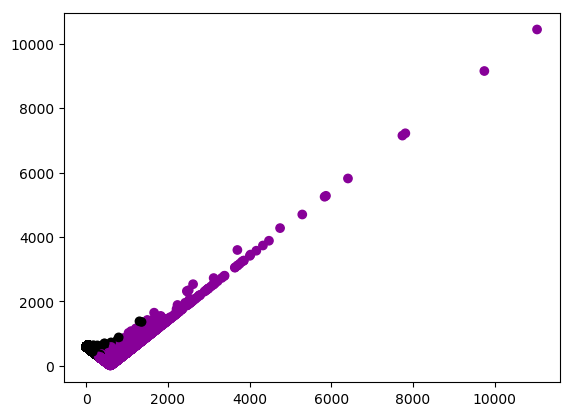

None

{'Intersection': 7999, 'Num_Experts': 34291, 'Num_Experts_Predicted': 8902}

{'Average Expert Stars': 3.5186702118066475,
 'Average User Stars': 3.5227586299639451,
 'Categories': ['Bars'],
 'MAE': 0.51715195686389737,
 'MSE': 0.53095143804664291,
 'Number of Businesses': 9868,
 'Number of Businesses with Experts': 7610}

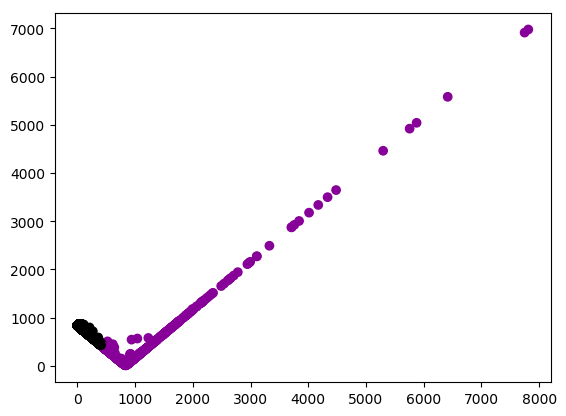

None

{'Intersection': 1162, 'Num_Experts': 6814, 'Num_Experts_Predicted': 1278}

{'Average Expert Stars': 3.6517187591180904,
 'Average User Stars': 3.3970768433244261,
 'Categories': ['Automotive'],
 'MAE': 0.94183180383412923,
 'MSE': 1.5635555887835597,
 'Number of Businesses': 9476,
 'Number of Businesses with Experts': 2619}

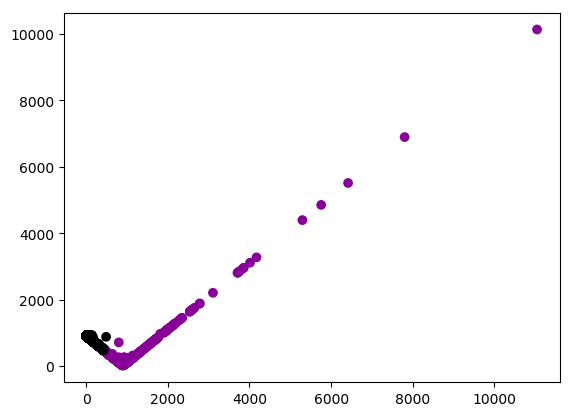

None

{'Intersection': 749, 'Num_Experts': 5784, 'Num_Experts_Predicted': 832}

{'Average Expert Stars': 3.8604654909199398,
 'Average User Stars': 3.5839788510136978,
 'Categories': ['Local Services'],
 'MAE': 0.85646744855193635,
 'MSE': 1.3616528260018166,
 'Number of Businesses': 9343,
 'Number of Businesses with Experts': 1965}

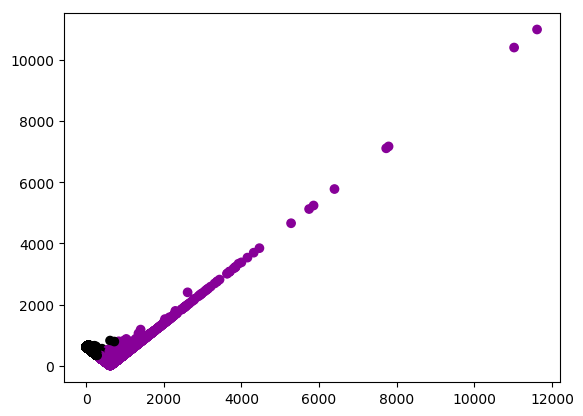

None

{'Intersection': 7271, 'Num_Experts': 30364, 'Num_Experts_Predicted': 8096}

{'Average Expert Stars': 3.6992549449821164,
 'Average User Stars': 3.6053378151011883,
 'Categories': ['Event Planning & Services'],
 'MAE': 0.60591719848855397,
 'MSE': 0.70644681810162624,
 'Number of Businesses': 8038,
 'Number of Businesses with Experts': 4503}

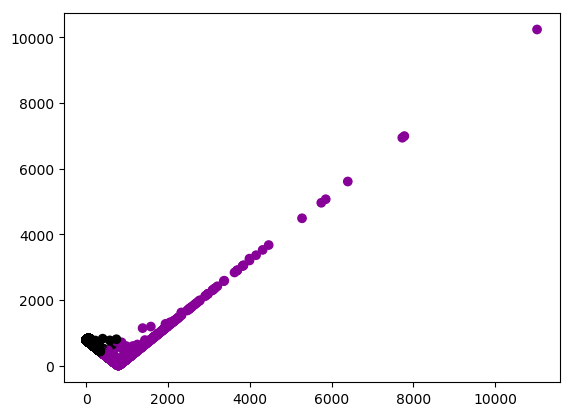

None

{'Intersection': 2806, 'Num_Experts': 13911, 'Num_Experts_Predicted': 3066}

{'Average Expert Stars': 3.9949573400482801,
 'Average User Stars': 3.9341228519717424,
 'Categories': ['Active Life'],
 'MAE': 0.62862925929447178,
 'MSE': 0.76412052084516746,
 'Number of Businesses': 7427,
 'Number of Businesses with Experts': 3089}

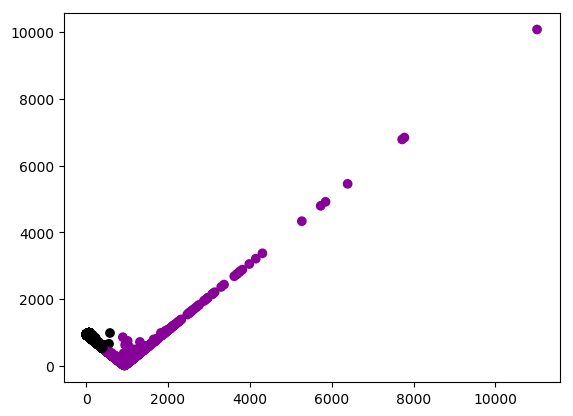

None

{'Intersection': 1410, 'Num_Experts': 8069, 'Num_Experts_Predicted': 1540}

{'Average Expert Stars': 3.6089230333598086,
 'Average User Stars': 3.4631329514600839,
 'Categories': ['Fashion'],
 'MAE': 0.76441036947926311,
 'MSE': 1.0333712682165692,
 'Number of Businesses': 6299,
 'Number of Businesses with Experts': 3542}

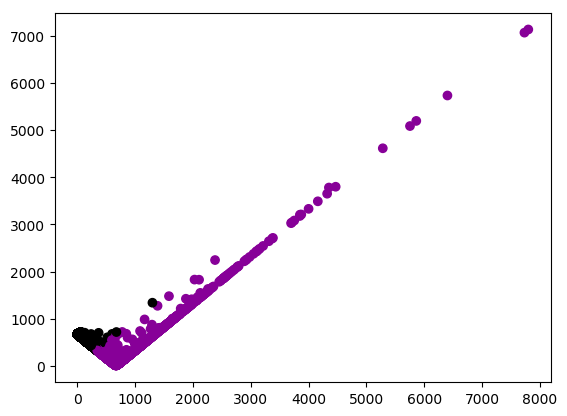

None

{'Intersection': 4749, 'Num_Experts': 22158, 'Num_Experts_Predicted': 5239}

{'Average Expert Stars': 3.5801120868803102,
 'Average User Stars': 3.5371466933447873,
 'Categories': ['Sandwiches'],
 'MAE': 0.62633517476832712,
 'MSE': 0.72164739817381285,
 'Number of Businesses': 5864,
 'Number of Businesses with Experts': 3917}

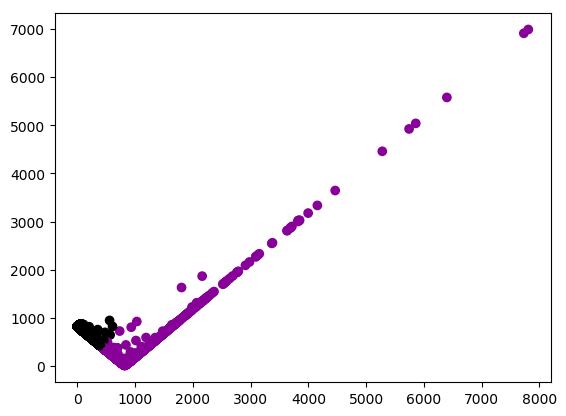

None

{'Intersection': 1961, 'Num_Experts': 11924, 'Num_Experts_Predicted': 2157}

{'Average Expert Stars': 3.2558050430900836,
 'Average User Stars': 2.9503072048797621,
 'Categories': ['Fast Food'],
 'MAE': 0.78571526127116142,
 'MSE': 1.0372093104332598,
 'Number of Businesses': 5792,
 'Number of Businesses with Experts': 3375}

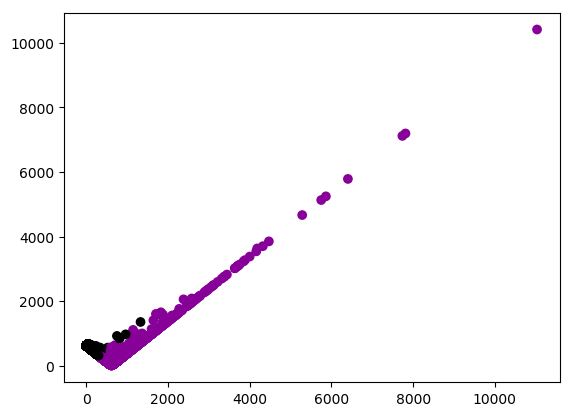

None

{'Intersection': 6536, 'Num_Experts': 28185, 'Num_Experts_Predicted': 7278}

{'Average Expert Stars': 3.3971154454053201,
 'Average User Stars': 3.3186548485485972,
 'Categories': ['American (Traditional)'],
 'MAE': 0.55200537788852333,
 'MSE': 0.57727641888730308,
 'Number of Businesses': 5737,
 'Number of Businesses with Experts': 4429}

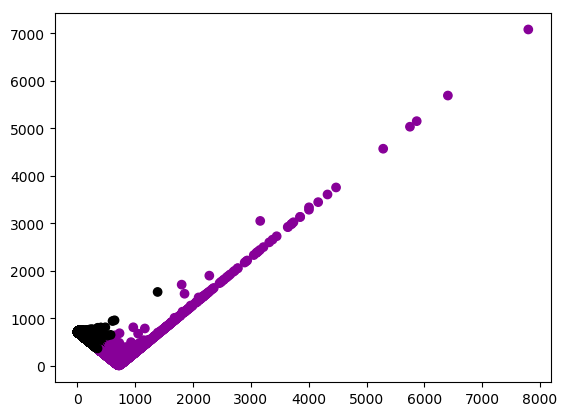

None

{'Intersection': 3295, 'Num_Experts': 17405, 'Num_Experts_Predicted': 3643}

{'Average Expert Stars': 3.4850135075807143,
 'Average User Stars': 3.4265776890653994,
 'Categories': ['Pizza'],
 'MAE': 0.66358052462060957,
 'MSE': 0.7929394324803668,
 'Number of Businesses': 5652,
 'Number of Businesses with Experts': 3179}

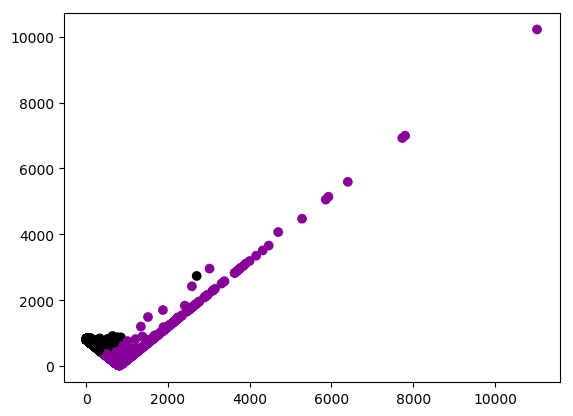

None

{'Intersection': 2763, 'Num_Experts': 16775, 'Num_Experts_Predicted': 3028}

{'Average Expert Stars': 3.6384847486652312,
 'Average User Stars': 3.6606285124044091,
 'Categories': ['Coffee & Tea'],
 'MAE': 0.61621640718077686,
 'MSE': 0.6858571700995062,
 'Number of Businesses': 5565,
 'Number of Businesses with Experts': 3860}

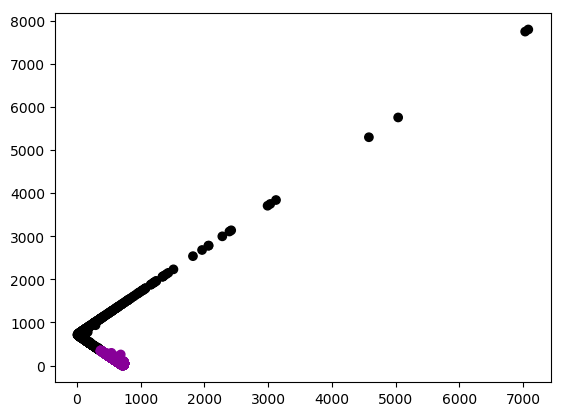

None

{'Intersection': 4664, 'Num_Experts': 5623, 'Num_Experts_Predicted': 72796}

{'Average Expert Stars': 3.9070109371473101,
 'Average User Stars': 3.9981398639850294,
 'Categories': ['Hair Salons'],
 'MAE': 0.77394170317567723,
 'MSE': 1.0898756390735804,
 'Number of Businesses': 5395,
 'Number of Businesses with Experts': 1217}

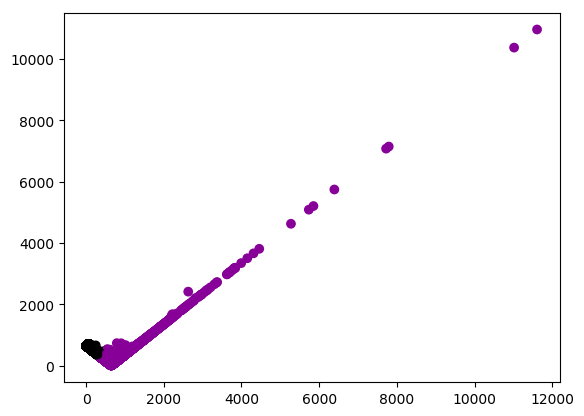

None

{'Intersection': 6555, 'Num_Experts': 26007, 'Num_Experts_Predicted': 7263}

{'Average Expert Stars': 3.5156318210528239,
 'Average User Stars': 3.2540682483252859,
 'Categories': ['Hotels & Travel'],
 'MAE': 0.72039590686235766,
 'MSE': 0.98731515013580162,
 'Number of Businesses': 5188,
 'Number of Businesses with Experts': 3010}

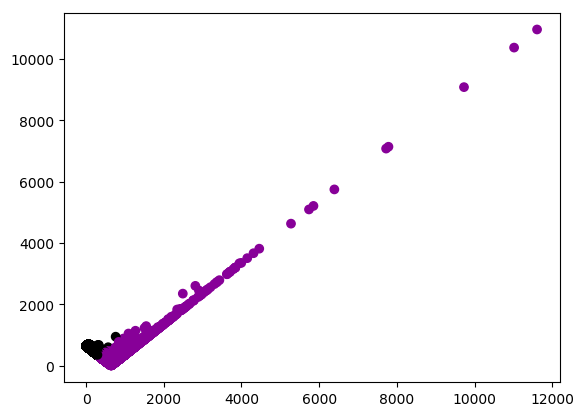

None

{'Intersection': 6327, 'Num_Experts': 26800, 'Num_Experts_Predicted': 7009}

{'Average Expert Stars': 3.8304335403740932,
 'Average User Stars': 3.8002110781941965,
 'Categories': ['Arts & Entertainment'],
 'MAE': 0.551996974206869,
 'MSE': 0.61150652119156512,
 'Number of Businesses': 5054,
 'Number of Businesses with Experts': 3451}

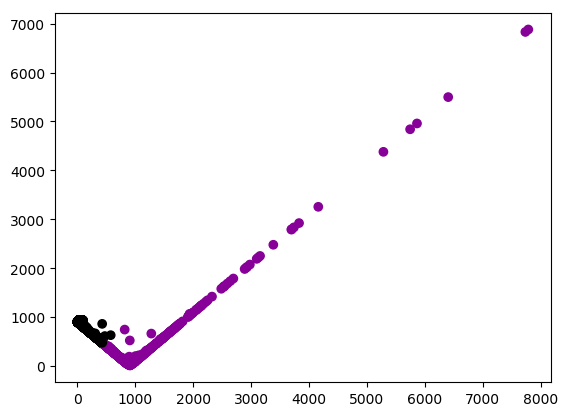

None

{'Intersection': 821, 'Num_Experts': 4915, 'Num_Experts_Predicted': 892}

{'Average Expert Stars': 3.7105502543841142,
 'Average User Stars': 3.4742595431751737,
 'Categories': ['Home & Garden'],
 'MAE': 0.78862448898204851,
 'MSE': 1.0886569571826232,
 'Number of Businesses': 4584,
 'Number of Businesses with Experts': 1766}

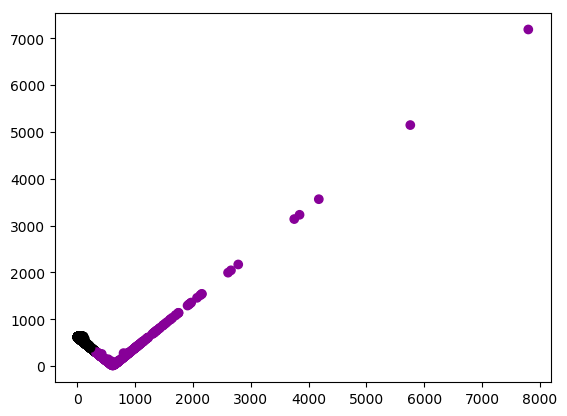

None

{'Intersection': 738, 'Num_Experts': 3473, 'Num_Experts_Predicted': 832}

{'Average Expert Stars': 3.7754606719556376,
 'Average User Stars': 3.5828809844683174,
 'Categories': ['Auto Repair'],
 'MAE': 0.96862976853476102,
 'MSE': 1.6507342173455797,
 'Number of Businesses': 4480,
 'Number of Businesses with Experts': 1291}

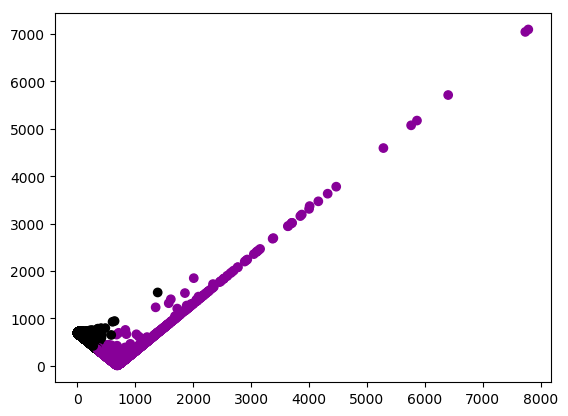

None

{'Intersection': 3603, 'Num_Experts': 18386, 'Num_Experts_Predicted': 4005}

{'Average Expert Stars': 3.5357289993563947,
 'Average User Stars': 3.5460361547437547,
 'Categories': ['Italian'],
 'MAE': 0.58684354274902628,
 'MSE': 0.63757193380986454,
 'Number of Businesses': 4411,
 'Number of Businesses with Experts': 2828}

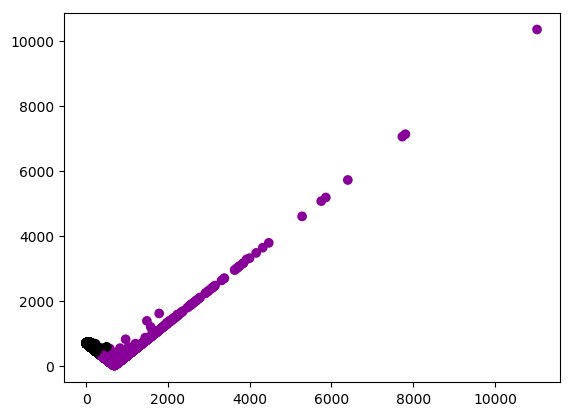

None

{'Intersection': 4094, 'Num_Experts': 20396, 'Num_Experts_Predicted': 4525}

{'Average Expert Stars': 3.2990428855998188,
 'Average User Stars': 3.0980812278379051,
 'Categories': ['Burgers'],
 'MAE': 0.66877597790137788,
 'MSE': 0.82241937713412583,
 'Number of Businesses': 4236,
 'Number of Businesses with Experts': 2920}

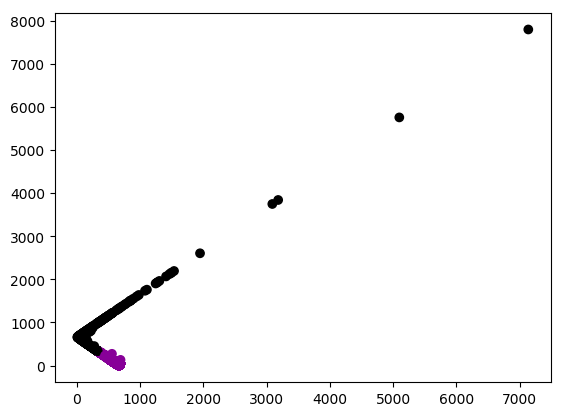

None

{'Intersection': 1793, 'Num_Experts': 2278, 'Num_Experts_Predicted': 40937}

{'Average Expert Stars': 3.2645164337555577,
 'Average User Stars': 3.8107092835868754,
 'Categories': ['Doctors'],
 'MAE': 1.1483055694573741,
 'MSE': 2.1304147167763436,
 'Number of Businesses': 4124,
 'Number of Businesses with Experts': 1013}

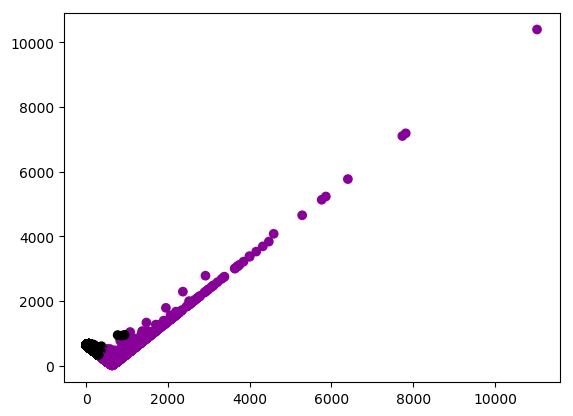

None

{'Intersection': 6060, 'Num_Experts': 27697, 'Num_Experts_Predicted': 6718}

{'Average Expert Stars': 3.5790921563987781,
 'Average User Stars': 3.5737371530145059,
 'Categories': ['Breakfast & Brunch'],
 'MAE': 0.52079886582806789,
 'MSE': 0.53760670363937846,
 'Number of Businesses': 4103,
 'Number of Businesses with Experts': 3180}

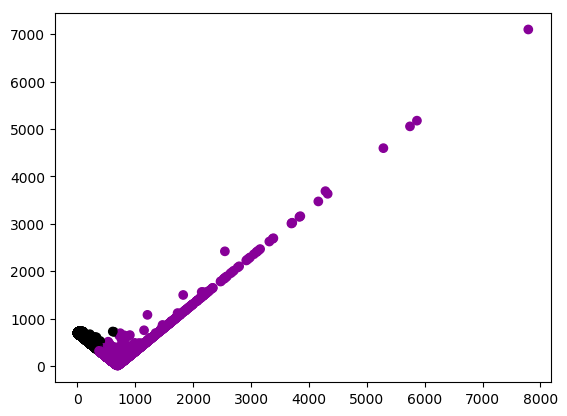

None

{'Intersection': 3385, 'Num_Experts': 17483, 'Num_Experts_Predicted': 3725}

{'Average Expert Stars': 3.4271434508144907,
 'Average User Stars': 3.4356380541741998,
 'Categories': ['Mexican'],
 'MAE': 0.61220459801585259,
 'MSE': 0.68181691157997537,
 'Number of Businesses': 3913,
 'Number of Businesses with Experts': 2751}

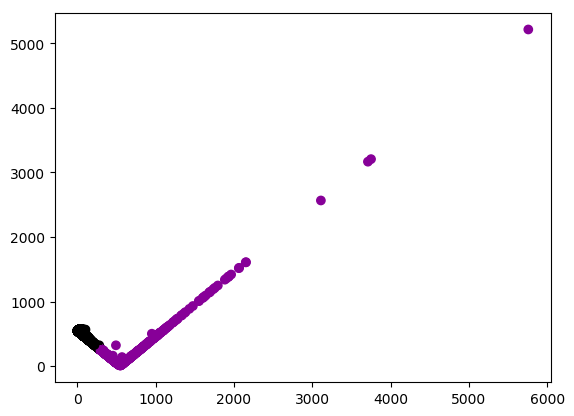

None

{'Intersection': 926, 'Num_Experts': 4372, 'Num_Experts_Predicted': 1024}

{'Average Expert Stars': 3.6998124592764206,
 'Average User Stars': 3.584234780802904,
 'Categories': ['Nail Salons'],
 'MAE': 0.87898898351874344,
 'MSE': 1.3218729863789667,
 'Number of Businesses': 3884,
 'Number of Businesses with Experts': 1345}

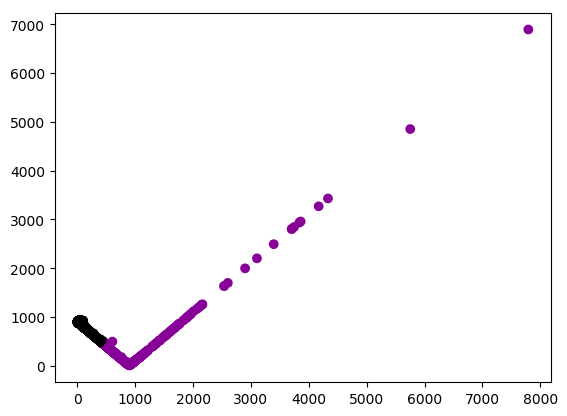

None

{'Intersection': 471, 'Num_Experts': 2580, 'Num_Experts_Predicted': 518}

{'Average Expert Stars': 3.7368313053692663,
 'Average User Stars': 3.5205110182669879,
 'Categories': ['Professional Services'],
 'MAE': 0.88383247765811324,
 'MSE': 1.5577254855363012,
 'Number of Businesses': 3865,
 'Number of Businesses with Experts': 532}

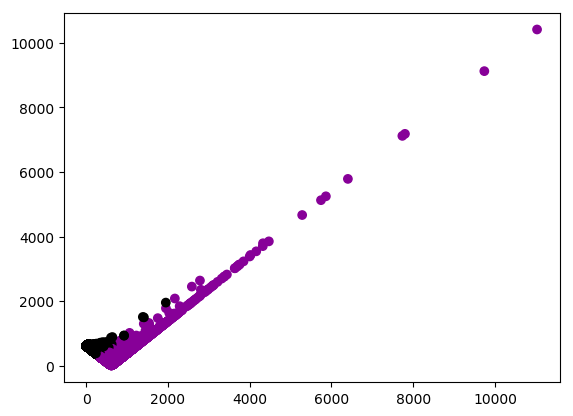

None

{'Intersection': 6586, 'Num_Experts': 28786, 'Num_Experts_Predicted': 7306}

{'Average Expert Stars': 3.5526752250561122,
 'Average User Stars': 3.5406250364253182,
 'Categories': ['American (New)'],
 'MAE': 0.47682068077615697,
 'MSE': 0.46047919661934161,
 'Number of Businesses': 3802,
 'Number of Businesses with Experts': 3093}

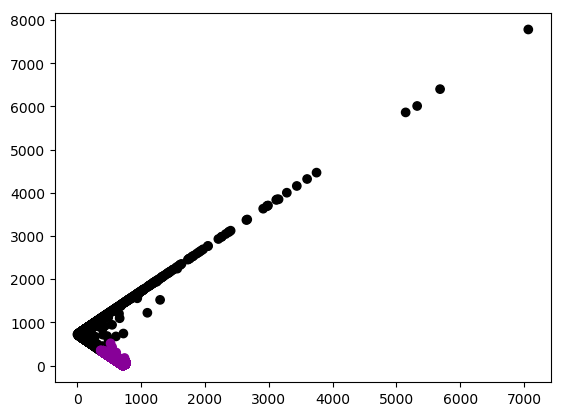

None

{'Intersection': 11588, 'Num_Experts': 14370, 'Num_Experts_Predicted': 106600}

{'Average Expert Stars': 3.3223140458071114,
 'Average User Stars': 3.2759938459995479,
 'Categories': ['Chinese'],
 'MAE': 0.58406996497075792,
 'MSE': 0.63182510639340872,
 'Number of Businesses': 3775,
 'Number of Businesses with Experts': 2476}

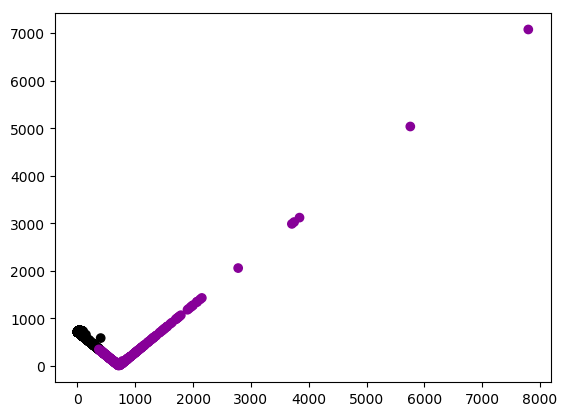

None

{'Intersection': 454, 'Num_Experts': 2043, 'Num_Experts_Predicted': 517}

{'Average Expert Stars': 3.4018691308691311,
 'Average User Stars': 3.0649621303551786,
 'Categories': ['Real Estate'],
 'MAE': 1.0822004628527317,
 'MSE': 2.0235244187907568,
 'Number of Businesses': 3729,
 'Number of Businesses with Experts': 500}

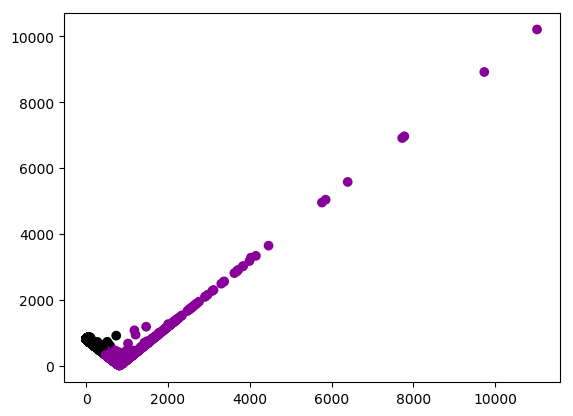

None

{'Intersection': 2297, 'Num_Experts': 13558, 'Num_Experts_Predicted': 2512}

{'Average Expert Stars': 3.8739770111331753,
 'Average User Stars': 3.9349259972650552,
 'Categories': ['Specialty Food'],
 'MAE': 0.55752986719429809,
 'MSE': 0.60061377953849659,
 'Number of Businesses': 3620,
 'Number of Businesses with Experts': 2186}

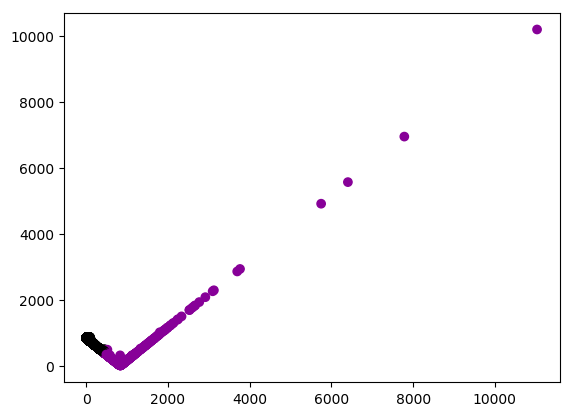

None

{'Intersection': 658, 'Num_Experts': 4620, 'Num_Experts_Predicted': 706}

{'Average Expert Stars': 3.9689936936679779,
 'Average User Stars': 3.9274438732558119,
 'Categories': ['Fitness & Instruction'],
 'MAE': 0.68047487376520688,
 'MSE': 0.89848679463136771,
 'Number of Businesses': 3615,
 'Number of Businesses with Experts': 1028}

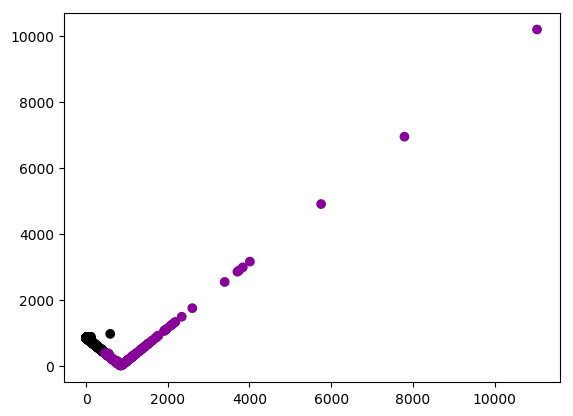

None

{'Intersection': 395, 'Num_Experts': 2997, 'Num_Experts_Predicted': 440}

{'Average Expert Stars': 4.053880748880748,
 'Average User Stars': 3.8696328424328699,
 'Categories': ['Pets'],
 'MAE': 0.80019251539242198,
 'MSE': 1.1750376847311435,
 'Number of Businesses': 3153,
 'Number of Businesses with Experts': 819}

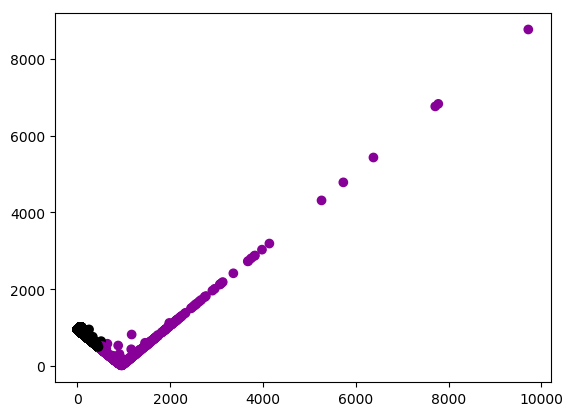

None

{'Intersection': 1040, 'Num_Experts': 7906, 'Num_Experts_Predicted': 1127}

{'Average Expert Stars': 3.5243570150924137,
 'Average User Stars': 3.4289014386055996,
 'Categories': ['Grocery'],
 'MAE': 0.63496121211354006,
 'MSE': 0.694214715412382,
 'Number of Businesses': 3044,
 'Number of Businesses with Experts': 1886}

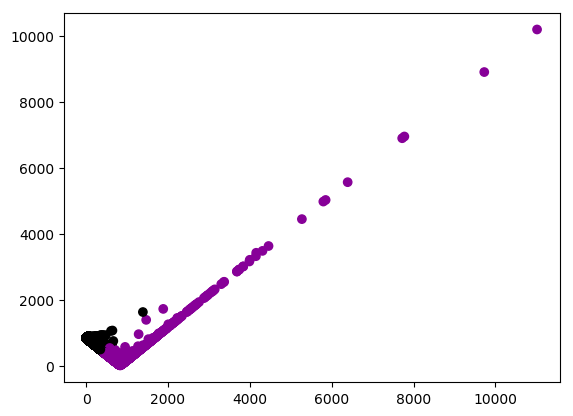

None

{'Intersection': 2197, 'Num_Experts': 13770, 'Num_Experts_Predicted': 2386}

{'Average Expert Stars': 3.7260591891517527,
 'Average User Stars': 3.7953122151447882,
 'Categories': ['Bakeries'],
 'MAE': 0.57566852421797809,
 'MSE': 0.63217852156496301,
 'Number of Businesses': 3014,
 'Number of Businesses with Experts': 1948}

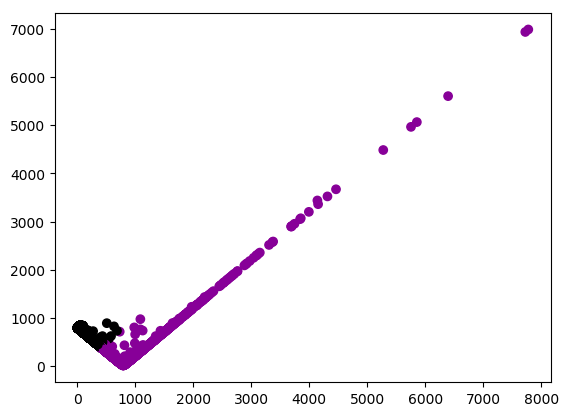

None

{'Intersection': 2546, 'Num_Experts': 14778, 'Num_Experts_Predicted': 2782}

{'Average Expert Stars': 3.651186492721068,
 'Average User Stars': 3.7753536125976708,
 'Categories': ['Cafes'],
 'MAE': 0.57782698106438535,
 'MSE': 0.63867429131087161,
 'Number of Businesses': 2812,
 'Number of Businesses with Experts': 1749}

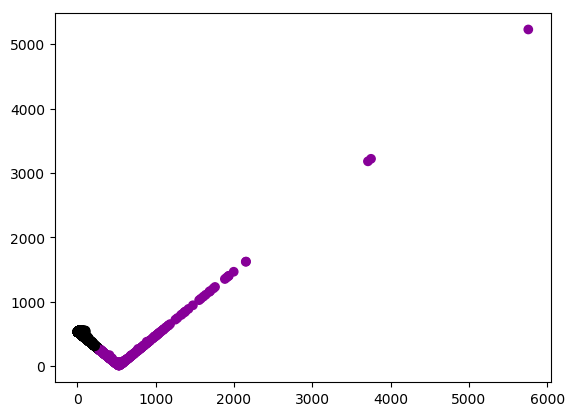

None

{'Intersection': 689, 'Num_Experts': 3342, 'Num_Experts_Predicted': 762}

{'Average Expert Stars': 3.9540145726714035,
 'Average User Stars': 3.9548140065912252,
 'Categories': ['Hair Removal'],
 'MAE': 0.75768730850064581,
 'MSE': 1.1180034627038662,
 'Number of Businesses': 2704,
 'Number of Businesses with Experts': 840}

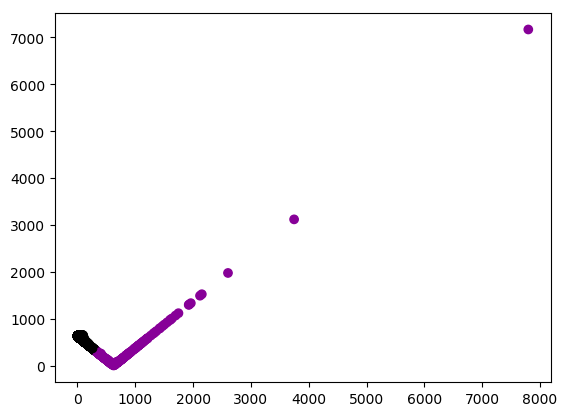

None

{'Intersection': 367, 'Num_Experts': 1726, 'Num_Experts_Predicted': 409}

{'Average Expert Stars': 4.213175675675676,
 'Average User Stars': 4.0497607334197792,
 'Categories': ['Dentists'],
 'MAE': 0.81912954196401544,
 'MSE': 1.3588252538241798,
 'Number of Businesses': 2683,
 'Number of Businesses with Experts': 444}

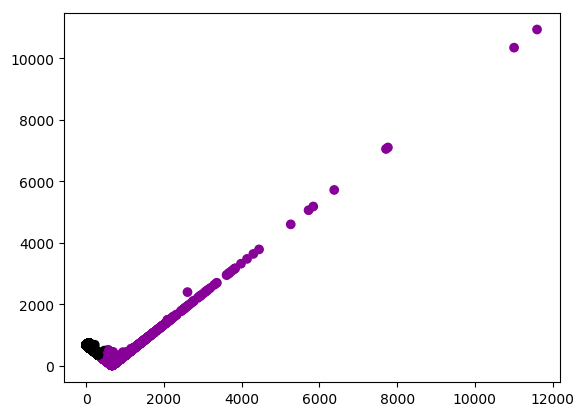

None

{'Intersection': 5508, 'Num_Experts': 21836, 'Num_Experts_Predicted': 6074}

{'Average Expert Stars': 3.4675795355703483,
 'Average User Stars': 3.26385109813017,
 'Categories': ['Hotels'],
 'MAE': 0.6342512574986171,
 'MSE': 0.72337511900295726,
 'Number of Businesses': 2548,
 'Number of Businesses with Experts': 1703}

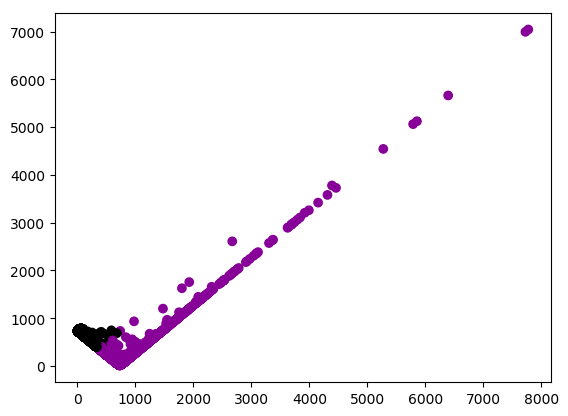

None

{'Intersection': 3314, 'Num_Experts': 17340, 'Num_Experts_Predicted': 3622}

{'Average Expert Stars': 3.7519689184281142,
 'Average User Stars': 3.8478128944355974,
 'Categories': ['Desserts'],
 'MAE': 0.51502289373242738,
 'MSE': 0.51271577565036408,
 'Number of Businesses': 2419,
 'Number of Businesses with Experts': 1718}

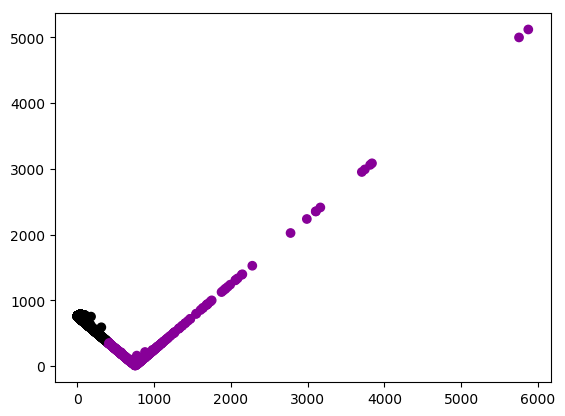

None

{'Intersection': 515, 'Num_Experts': 3272, 'Num_Experts_Predicted': 558}

{'Average Expert Stars': 3.9458454655560353,
 'Average User Stars': 3.9636632334606077,
 'Categories': ['Skin Care'],
 'MAE': 0.75885480188878296,
 'MSE': 1.0815458936181421,
 'Number of Businesses': 2398,
 'Number of Businesses with Experts': 601}

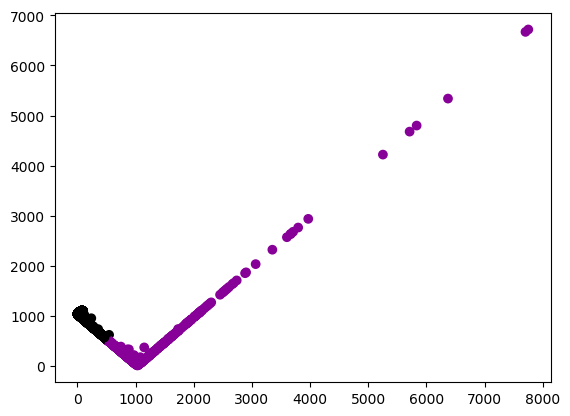

None

{'Intersection': 678, 'Num_Experts': 4130, 'Num_Experts_Predicted': 746}

{'Average Expert Stars': 3.6290760229619425,
 'Average User Stars': 3.5094125863540269,
 'Categories': ["Women's Clothing"],
 'MAE': 0.76032856485729194,
 'MSE': 0.99237202541238922,
 'Number of Businesses': 2355,
 'Number of Businesses with Experts': 1270}

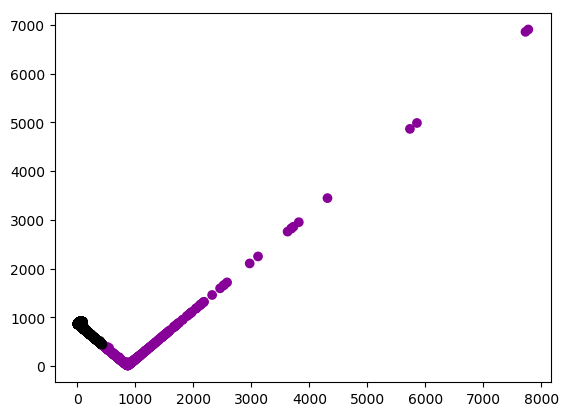

None

{'Intersection': 667, 'Num_Experts': 3640, 'Num_Experts_Predicted': 724}

{'Average Expert Stars': 4.0762762790392264,
 'Average User Stars': 3.9738930941638797,
 'Categories': ['Education'],
 'MAE': 0.65413167689538709,
 'MSE': 0.81597570268681363,
 'Number of Businesses': 2209,
 'Number of Businesses with Experts': 572}

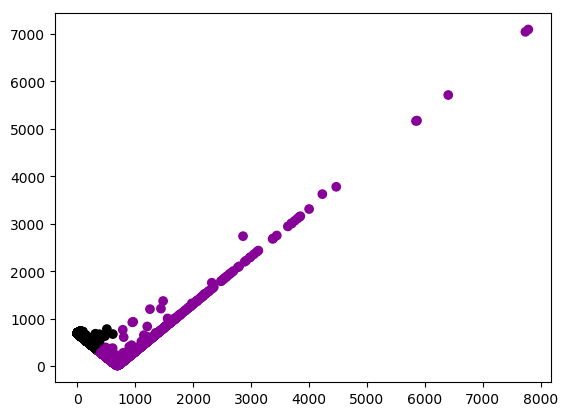

None

{'Intersection': 2893, 'Num_Experts': 15046, 'Num_Experts_Predicted': 3191}

{'Average Expert Stars': 3.4601026574574694,
 'Average User Stars': 3.5772710601233157,
 'Categories': ['Japanese'],
 'MAE': 0.52192032308032021,
 'MSE': 0.49525672314386521,
 'Number of Businesses': 2186,
 'Number of Businesses with Experts': 1658}

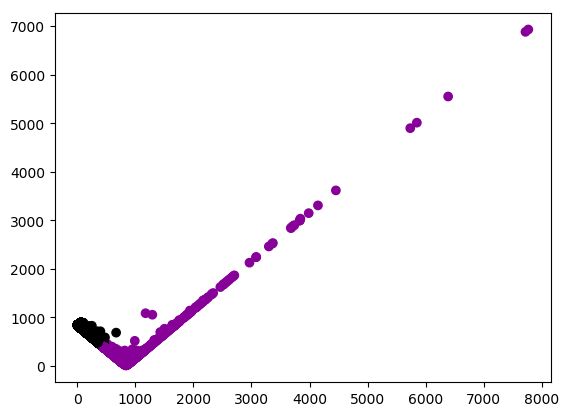

None

{'Intersection': 1530, 'Num_Experts': 10311, 'Num_Experts_Predicted': 1656}

{'Average Expert Stars': 3.6860708721154176,
 'Average User Stars': 3.7763508675570669,
 'Categories': ['Ice Cream & Frozen Yogurt'],
 'MAE': 0.60577447503766269,
 'MSE': 0.67686735594975689,
 'Number of Businesses': 2159,
 'Number of Businesses with Experts': 1378}

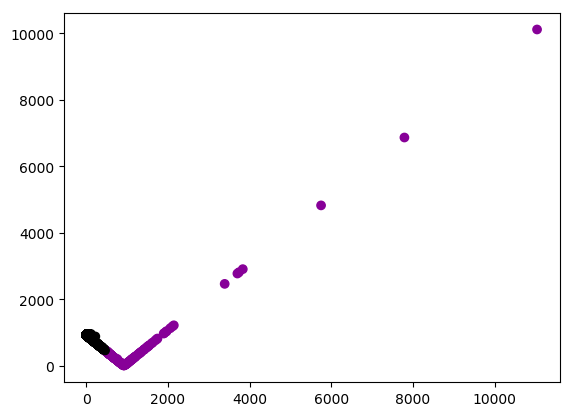

None

{'Intersection': 244, 'Num_Experts': 2179, 'Num_Experts_Predicted': 269}

{'Average Expert Stars': 3.9738400488400494,
 'Average User Stars': 3.830565807326221,
 'Categories': ['Pet Services'],
 'MAE': 0.85396335076054131,
 'MSE': 1.2879893574033023,
 'Number of Businesses': 2113,
 'Number of Businesses with Experts': 455}

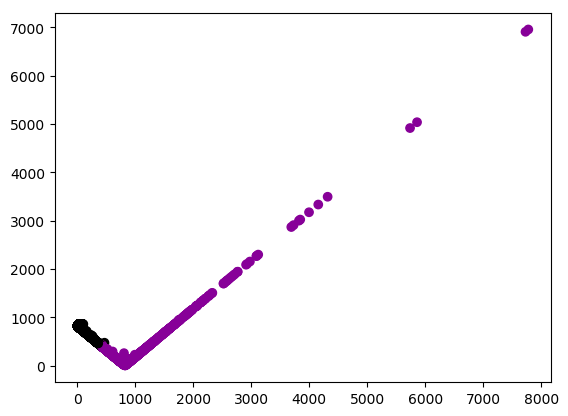

None

{'Intersection': 1450, 'Num_Experts': 7262, 'Num_Experts_Predicted': 1569}

{'Average Expert Stars': 3.7931944589364872,
 'Average User Stars': 3.8024025396872903,
 'Categories': ['Day Spas'],
 'MAE': 0.74367909722321979,
 'MSE': 1.0027999284846192,
 'Number of Businesses': 2084,
 'Number of Businesses with Experts': 634}

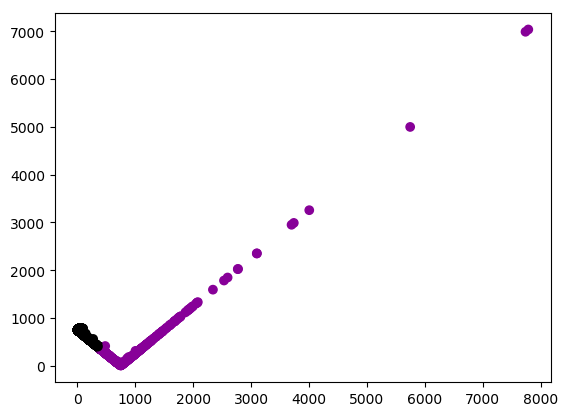

None

{'Intersection': 704, 'Num_Experts': 3767, 'Num_Experts_Predicted': 772}

{'Average Expert Stars': 3.9152435091964506,
 'Average User Stars': 3.9232345951699013,
 'Categories': ['Massage'],
 'MAE': 0.74301962578455782,
 'MSE': 1.0148312871265941,
 'Number of Businesses': 2068,
 'Number of Businesses with Experts': 561}

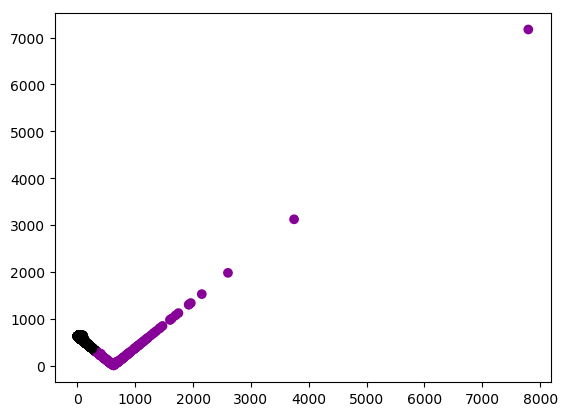

None

{'Intersection': 326, 'Num_Experts': 1510, 'Num_Experts_Predicted': 362}

{'Average Expert Stars': 4.1933933933933929,
 'Average User Stars': 4.0383905699377962,
 'Categories': ['General Dentistry'],
 'MAE': 0.83794029791692382,
 'MSE': 1.4299141504625381,
 'Number of Businesses': 2056,
 'Number of Businesses with Experts': 333}

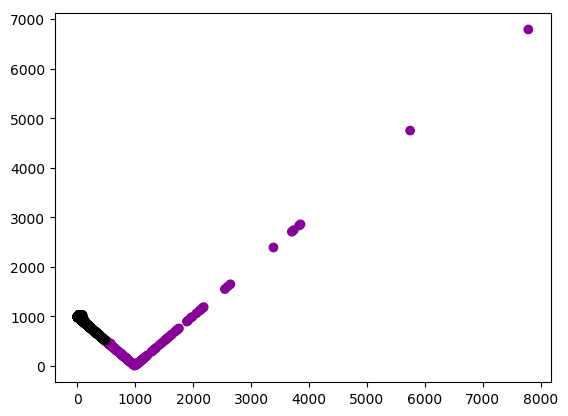

None

{'Intersection': 219, 'Num_Experts': 1195, 'Num_Experts_Predicted': 243}

{'Average Expert Stars': 3.5611793154761897,
 'Average User Stars': 2.9682179803285469,
 'Categories': ['Financial Services'],
 'MAE': 1.2233790081186597,
 'MSE': 2.3201456358625023,
 'Number of Businesses': 2053,
 'Number of Businesses with Experts': 448}

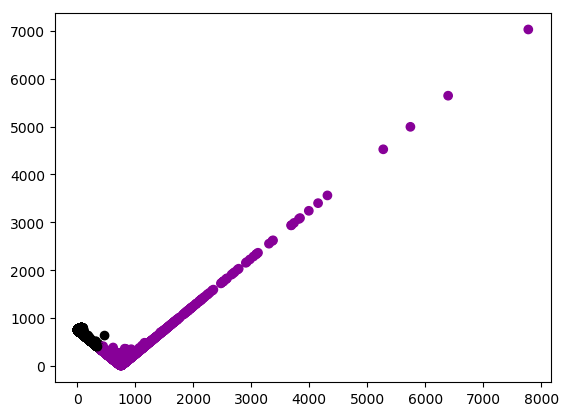

None

{'Intersection': 2166, 'Num_Experts': 13023, 'Num_Experts_Predicted': 2359}

{'Average Expert Stars': 3.4884578474685206,
 'Average User Stars': 3.5593283336597485,
 'Categories': ['Pubs'],
 'MAE': 0.49774003748520662,
 'MSE': 0.48350703707357967,
 'Number of Businesses': 2024,
 'Number of Businesses with Experts': 1485}

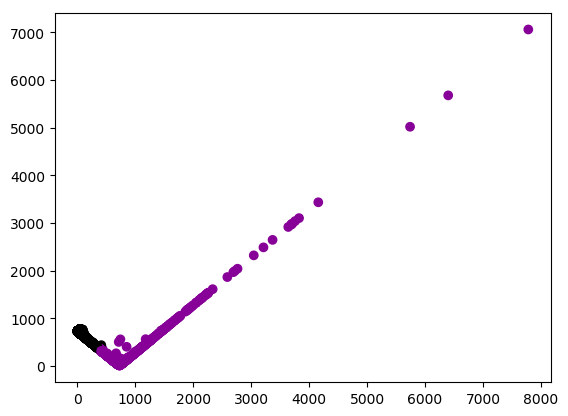

None

{'Intersection': 1245, 'Num_Experts': 7362, 'Num_Experts_Predicted': 1375}

{'Average Expert Stars': 3.2501793288340175,
 'Average User Stars': 3.0457974036823425,
 'Categories': ['Chicken Wings'],
 'MAE': 0.74028393056475661,
 'MSE': 0.9344043588807649,
 'Number of Businesses': 2019,
 'Number of Businesses with Experts': 1136}

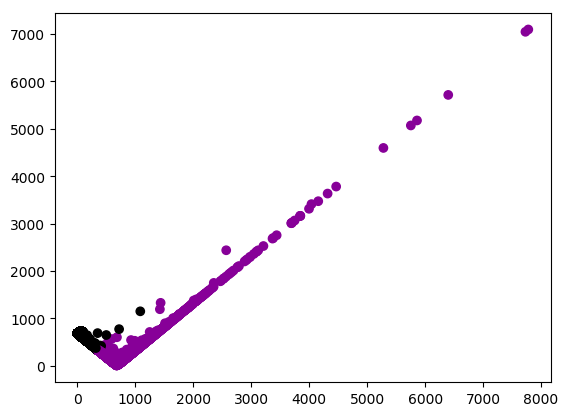

None

{'Intersection': 3729, 'Num_Experts': 18298, 'Num_Experts_Predicted': 4158}

{'Average Expert Stars': 3.5718598699545208,
 'Average User Stars': 3.5832293667693516,
 'Categories': ['Seafood'],
 'MAE': 0.50683516377812832,
 'MSE': 0.4786738558316147,
 'Number of Businesses': 1981,
 'Number of Businesses with Experts': 1487}

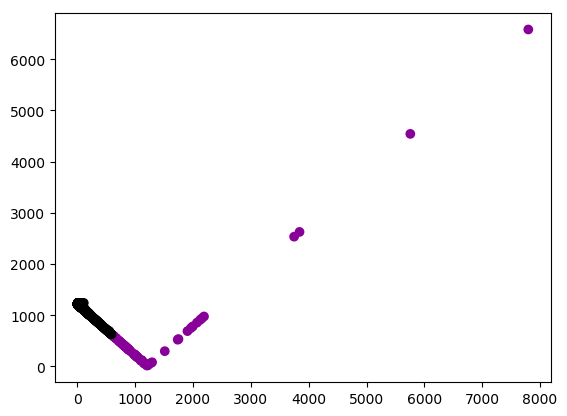

None

{'Intersection': 78, 'Num_Experts': 824, 'Num_Experts_Predicted': 87}

{'Average Expert Stars': 3.9191740412979352,
 'Average User Stars': 3.6609734805485474,
 'Categories': ['Contractors'],
 'MAE': 0.95733674722899431,
 'MSE': 1.6953898099105826,
 'Number of Businesses': 1939,
 'Number of Businesses with Experts': 113}

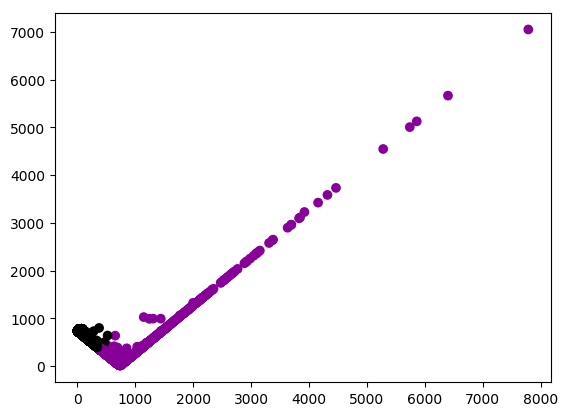

None

{'Intersection': 2546, 'Num_Experts': 13765, 'Num_Experts_Predicted': 2783}

{'Average Expert Stars': 3.5874316194977163,
 'Average User Stars': 3.5882522356544682,
 'Categories': ['Salad'],
 'MAE': 0.57126556385138216,
 'MSE': 0.58418936284467216,
 'Number of Businesses': 1850,
 'Number of Businesses with Experts': 1275}

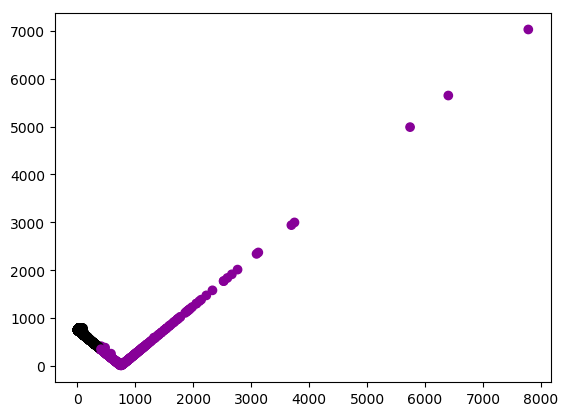

None

{'Intersection': 637, 'Num_Experts': 3437, 'Num_Experts_Predicted': 685}

{'Average Expert Stars': 3.8733101288430514,
 'Average User Stars': 3.7065569842334236,
 'Categories': ['Gyms'],
 'MAE': 0.70995947003462967,
 'MSE': 0.92892675734699981,
 'Number of Businesses': 1836,
 'Number of Businesses with Experts': 603}

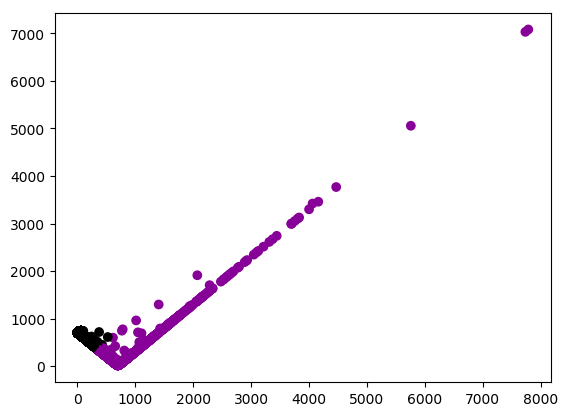

None

{'Intersection': 2619, 'Num_Experts': 14140, 'Num_Experts_Predicted': 2881}

{'Average Expert Stars': 3.476366275096721,
 'Average User Stars': 3.5827558800608434,
 'Categories': ['Sushi Bars'],
 'MAE': 0.5177924118319478,
 'MSE': 0.50835382678562202,
 'Number of Businesses': 1833,
 'Number of Businesses with Experts': 1332}

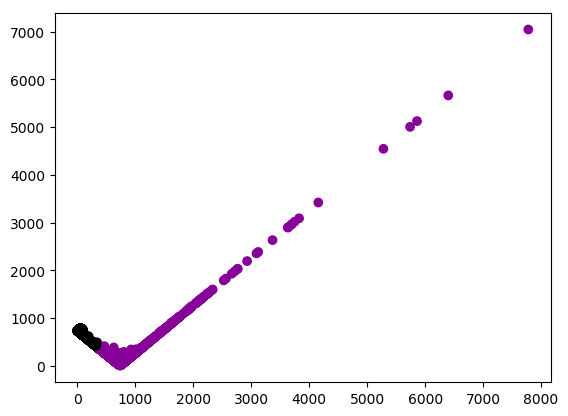

None

{'Intersection': 1831, 'Num_Experts': 10007, 'Num_Experts_Predicted': 2011}

{'Average Expert Stars': 3.2411872302257283,
 'Average User Stars': 3.2449247173481006,
 'Categories': ['Sports Bars'],
 'MAE': 0.5485482021546918,
 'MSE': 0.5423621255964316,
 'Number of Businesses': 1781,
 'Number of Businesses with Experts': 1252}

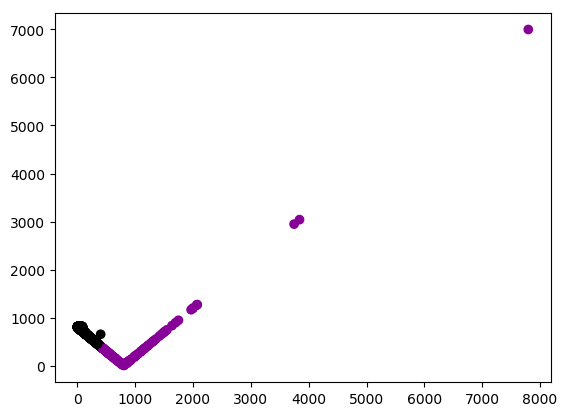

None

{'Intersection': 198, 'Num_Experts': 968, 'Num_Experts_Predicted': 215}

{'Average Expert Stars': 3.2388338833883386,
 'Average User Stars': 2.9451618672721129,
 'Categories': ['Apartments'],
 'MAE': 1.1275363316240175,
 'MSE': 1.9985285601990019,
 'Number of Businesses': 1776,
 'Number of Businesses with Experts': 202}

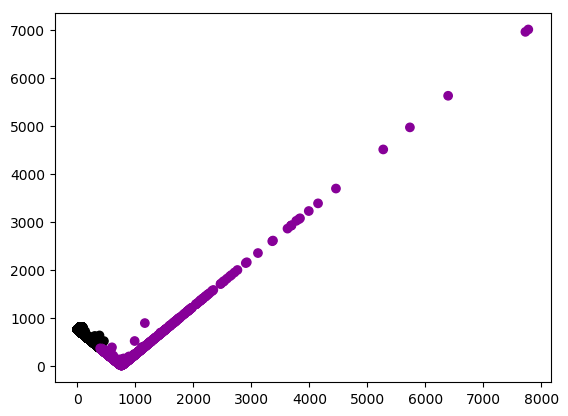

None

{'Intersection': 1906, 'Num_Experts': 10205, 'Num_Experts_Predicted': 2085}

{'Average Expert Stars': 3.6886182351064067,
 'Average User Stars': 3.7715890357025499,
 'Categories': ['Caterers'],
 'MAE': 0.58598902529432051,
 'MSE': 0.63774048412539797,
 'Number of Businesses': 1714,
 'Number of Businesses with Experts': 1005}

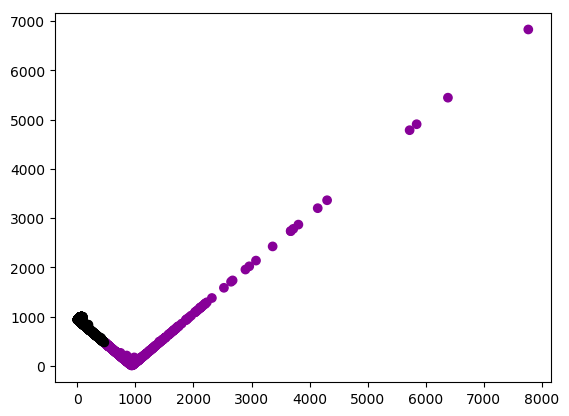

None

{'Intersection': 634, 'Num_Experts': 3665, 'Num_Experts_Predicted': 693}

{'Average Expert Stars': 3.9451049283213018,
 'Average User Stars': 3.8557308601400102,
 'Categories': ['Flowers & Gifts'],
 'MAE': 0.6461638471096145,
 'MSE': 0.80061710319635138,
 'Number of Businesses': 1699,
 'Number of Businesses with Experts': 738}

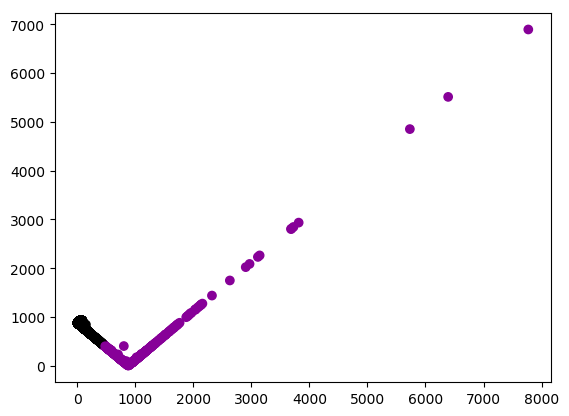

None

{'Intersection': 539, 'Num_Experts': 2832, 'Num_Experts_Predicted': 594}

{'Average Expert Stars': 3.8695714842687692,
 'Average User Stars': 3.6786049370035014,
 'Categories': ['Sporting Goods'],
 'MAE': 0.76119337419406508,
 'MSE': 1.0516114736708602,
 'Number of Businesses': 1662,
 'Number of Businesses with Experts': 702}

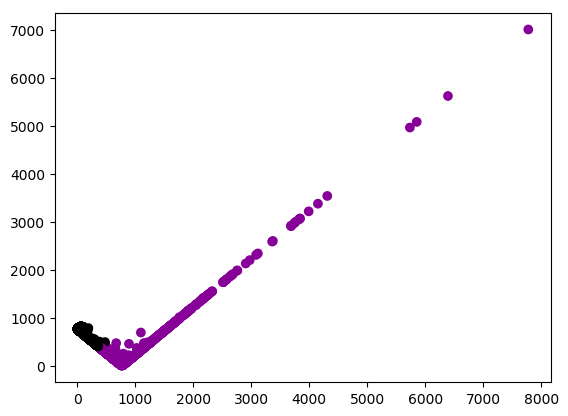

None

{'Intersection': 2106, 'Num_Experts': 11894, 'Num_Experts_Predicted': 2311}

{'Average Expert Stars': 3.7589717506151179,
 'Average User Stars': 3.8001445209920837,
 'Categories': ['Wine & Spirits'],
 'MAE': 0.52909296230455138,
 'MSE': 0.53555952992834888,
 'Number of Businesses': 1657,
 'Number of Businesses with Experts': 1197}

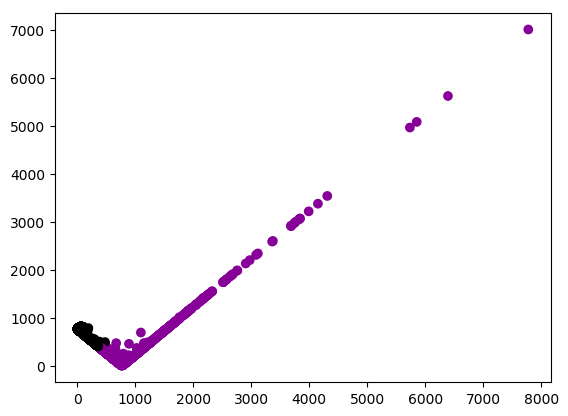

None

{'Intersection': 2106, 'Num_Experts': 11894, 'Num_Experts_Predicted': 2311}

{'Average Expert Stars': 3.7589717506151179,
 'Average User Stars': 3.8001445209920837,
 'Categories': ['Beer'],
 'MAE': 0.52909296230455138,
 'MSE': 0.53555952992834888,
 'Number of Businesses': 1657,
 'Number of Businesses with Experts': 1197}

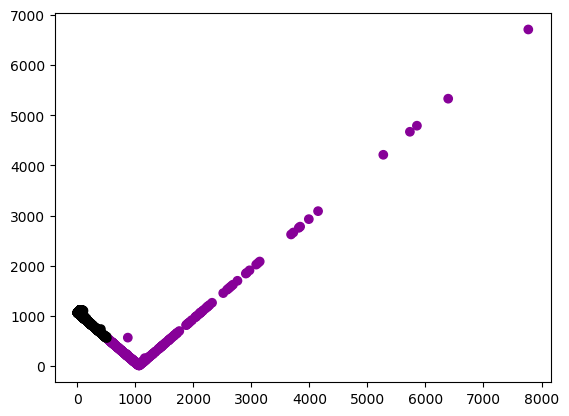

None

{'Intersection': 467, 'Num_Experts': 2996, 'Num_Experts_Predicted': 512}

{'Average Expert Stars': 3.7453985574428277,
 'Average User Stars': 3.4986695266466721,
 'Categories': ['Cosmetics & Beauty Supply'],
 'MAE': 0.78636671887912468,
 'MSE': 1.0525290972074604,
 'Number of Businesses': 1651,
 'Number of Businesses with Experts': 576}

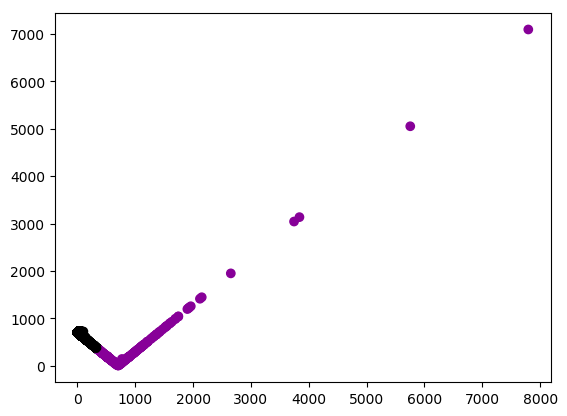

None

{'Intersection': 372, 'Num_Experts': 1976, 'Num_Experts_Predicted': 408}

{'Average Expert Stars': 3.7387886018604966,
 'Average User Stars': 3.5193695918742463,
 'Categories': ['Oil Change Stations'],
 'MAE': 0.98647177902748684,
 'MSE': 1.6559997315122503,
 'Number of Businesses': 1635,
 'Number of Businesses with Experts': 459}

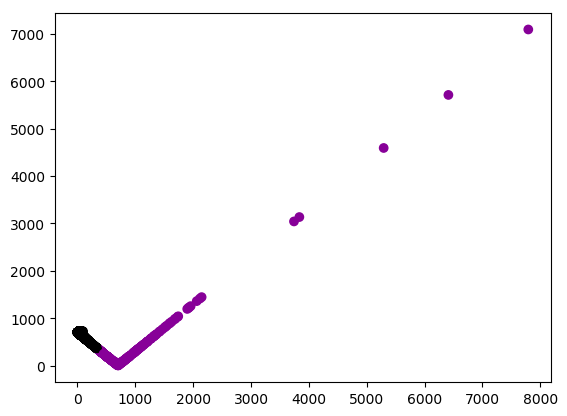

None

{'Intersection': 419, 'Num_Experts': 2023, 'Num_Experts_Predicted': 454}

{'Average Expert Stars': 3.8376825095882068,
 'Average User Stars': 3.5179576690899257,
 'Categories': ['Tires'],
 'MAE': 0.94817724443944362,
 'MSE': 1.5757748025060669,
 'Number of Businesses': 1633,
 'Number of Businesses with Experts': 509}

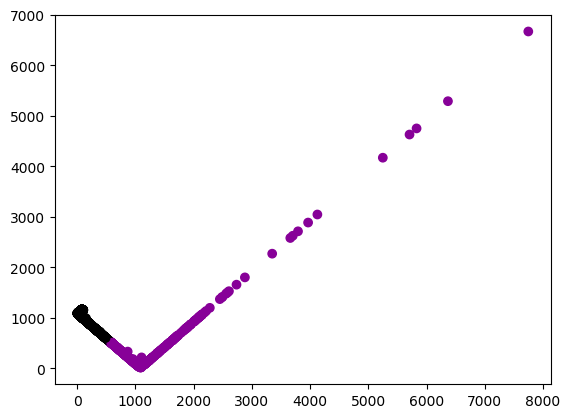

None

{'Intersection': 471, 'Num_Experts': 2768, 'Num_Experts_Predicted': 511}

{'Average Expert Stars': 3.7462389034025416,
 'Average User Stars': 3.641954338911872,
 'Categories': ['Accessories'],
 'MAE': 0.76728682717009433,
 'MSE': 1.0716457240961292,
 'Number of Businesses': 1600,
 'Number of Businesses with Experts': 738}

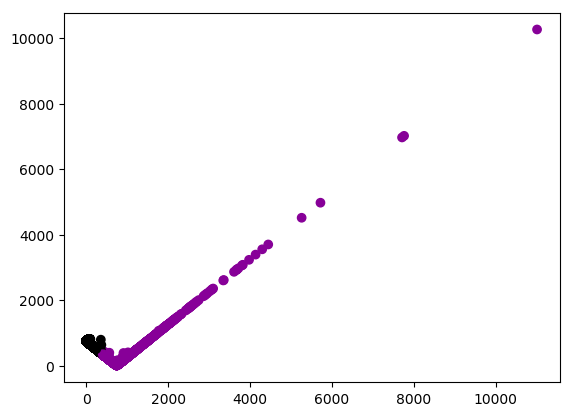

None

{'Intersection': 2835, 'Num_Experts': 13509, 'Num_Experts_Predicted': 3119}

{'Average Expert Stars': 3.7428507844243377,
 'Average User Stars': 3.6871993942364343,
 'Categories': ['Venues & Event Spaces'],
 'MAE': 0.56225436143680241,
 'MSE': 0.59857016344817571,
 'Number of Businesses': 1565,
 'Number of Businesses with Experts': 1040}

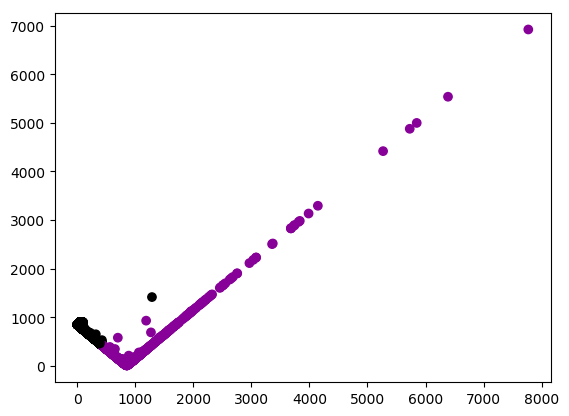

None

{'Intersection': 1325, 'Num_Experts': 8269, 'Num_Experts_Predicted': 1469}

{'Average Expert Stars': 3.6585702481608178,
 'Average User Stars': 3.6261664666978337,
 'Categories': ['Delis'],
 'MAE': 0.61236766794503494,
 'MSE': 0.6812494149192726,
 'Number of Businesses': 1564,
 'Number of Businesses with Experts': 984}

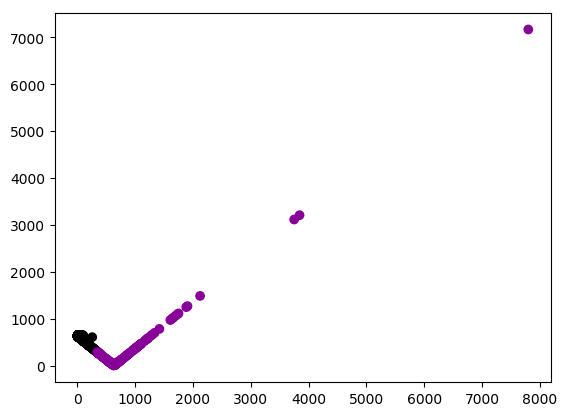

None

{'Intersection': 303, 'Num_Experts': 1358, 'Num_Experts_Predicted': 335}

{'Average Expert Stars': 4.0252965303527102,
 'Average User Stars': 4.0092358689383003,
 'Categories': ['Hair Stylists'],
 'MAE': 0.69804354660028367,
 'MSE': 0.97843993027519938,
 'Number of Businesses': 1557,
 'Number of Businesses with Experts': 267}

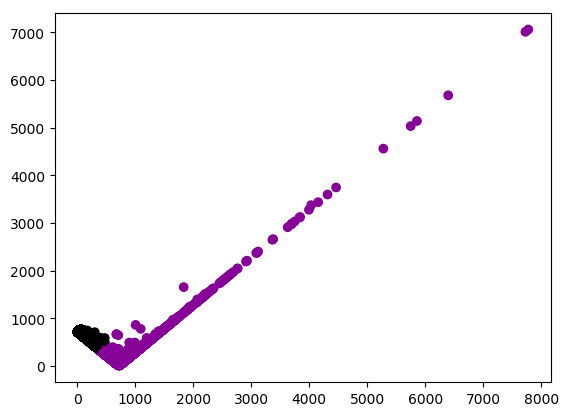

None

{'Intersection': 3016, 'Num_Experts': 15405, 'Num_Experts_Predicted': 3290}

{'Average Expert Stars': 3.4793633605958676,
 'Average User Stars': 3.5722000817218831,
 'Categories': ['Asian Fusion'],
 'MAE': 0.52045340133784479,
 'MSE': 0.50911120501407603,
 'Number of Businesses': 1554,
 'Number of Businesses with Experts': 1115}

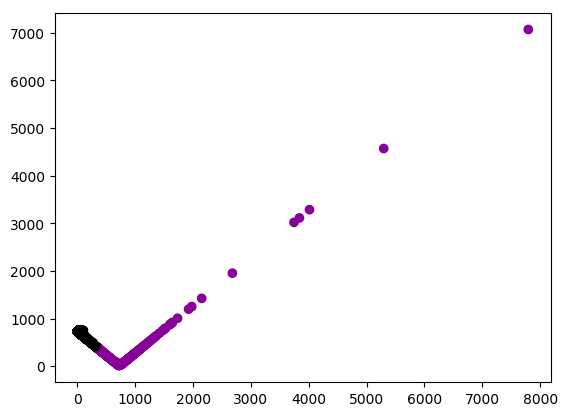

None

{'Intersection': 307, 'Num_Experts': 1717, 'Num_Experts_Predicted': 341}

{'Average Expert Stars': 3.9788186653369904,
 'Average User Stars': 3.9635369054800953,
 'Categories': ['Barbers'],
 'MAE': 0.85172435458801021,
 'MSE': 1.2520541850644016,
 'Number of Businesses': 1543,
 'Number of Businesses with Experts': 382}

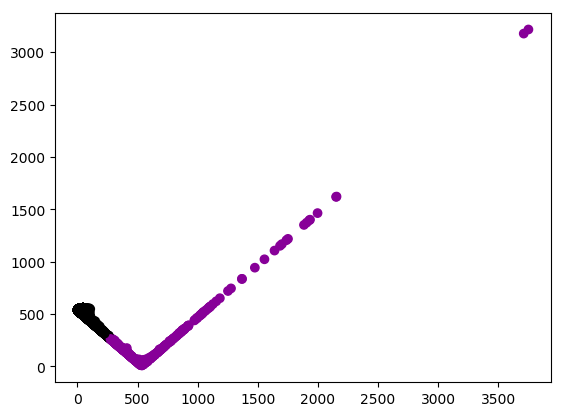

None

{'Intersection': 466, 'Num_Experts': 2221, 'Num_Experts_Predicted': 515}

{'Average Expert Stars': 4.0122823332291491,
 'Average User Stars': 4.0743014984642567,
 'Categories': ['Waxing'],
 'MAE': 0.7390849786150766,
 'MSE': 1.1105294154373995,
 'Number of Businesses': 1483,
 'Number of Businesses with Experts': 439}

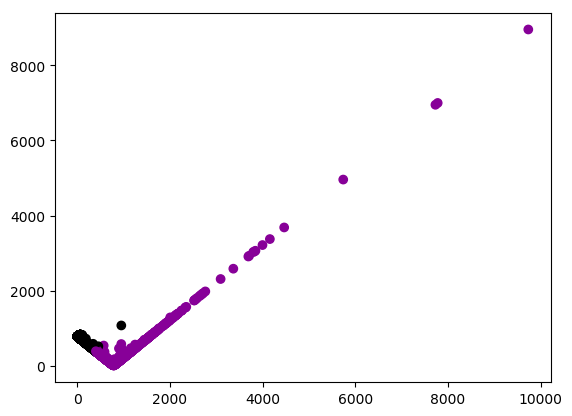

None

{'Intersection': 1407, 'Num_Experts': 9447, 'Num_Experts_Predicted': 1554}

{'Average Expert Stars': 3.6572166346262303,
 'Average User Stars': 3.7802936322219463,
 'Categories': ['Mediterranean'],
 'MAE': 0.58098281730501899,
 'MSE': 0.62533701948076481,
 'Number of Businesses': 1482,
 'Number of Businesses with Experts': 939}

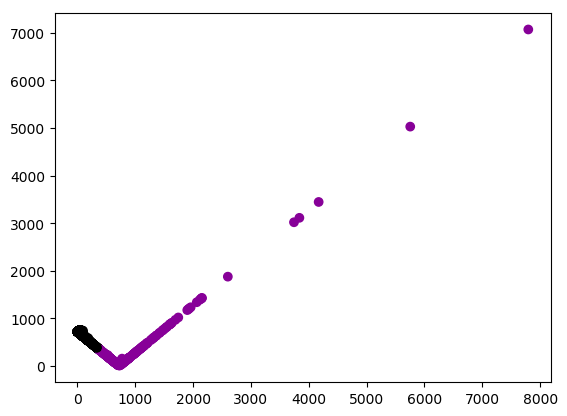

None

{'Intersection': 386, 'Num_Experts': 1927, 'Num_Experts_Predicted': 420}

{'Average Expert Stars': 3.8240900383141767,
 'Average User Stars': 3.612298463981042,
 'Categories': ['Auto Parts & Supplies'],
 'MAE': 0.89065158849216497,
 'MSE': 1.376309303248928,
 'Number of Businesses': 1479,
 'Number of Businesses with Experts': 522}

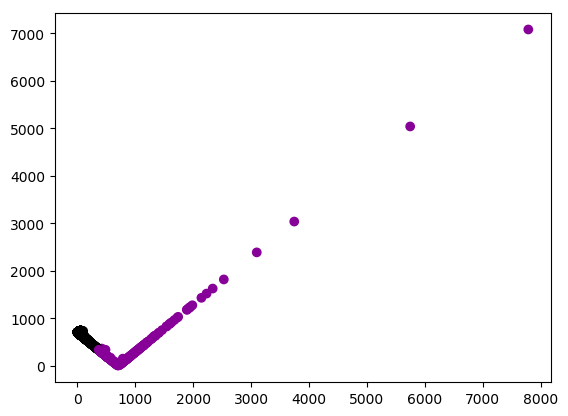

None

{'Intersection': 398, 'Num_Experts': 2255, 'Num_Experts_Predicted': 429}

{'Average Expert Stars': 3.9159688654643818,
 'Average User Stars': 3.7283492914314111,
 'Categories': ['Trainers'],
 'MAE': 0.73889631814296031,
 'MSE': 1.0937436538118417,
 'Number of Businesses': 1478,
 'Number of Businesses with Experts': 446}

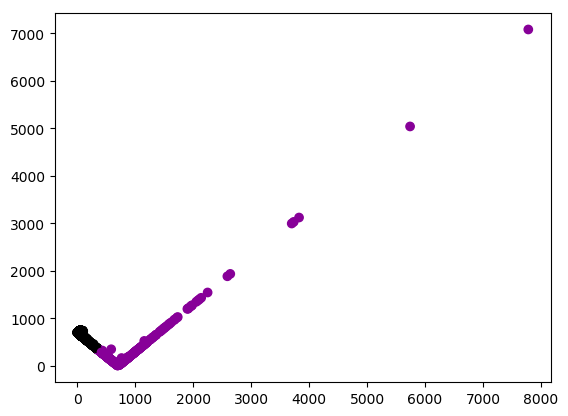

None

{'Intersection': 535, 'Num_Experts': 2188, 'Num_Experts_Predicted': 588}

{'Average Expert Stars': 3.598192021599083,
 'Average User Stars': 3.3246719007086045,
 'Categories': ['Furniture Stores'],
 'MAE': 0.85173112096154346,
 'MSE': 1.2255007546489776,
 'Number of Businesses': 1455,
 'Number of Businesses with Experts': 647}

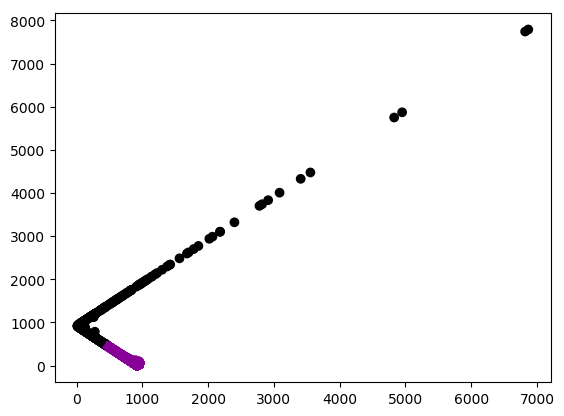

None

{'Intersection': 2580, 'Num_Experts': 3169, 'Num_Experts_Predicted': 38585}

{'Average Expert Stars': 3.157017470453912,
 'Average User Stars': 3.4677729979671028,
 'Categories': ['Car Dealers'],
 'MAE': 1.0819916514649897,
 'MSE': 1.8289973086814049,
 'Number of Businesses': 1455,
 'Number of Businesses with Experts': 366}

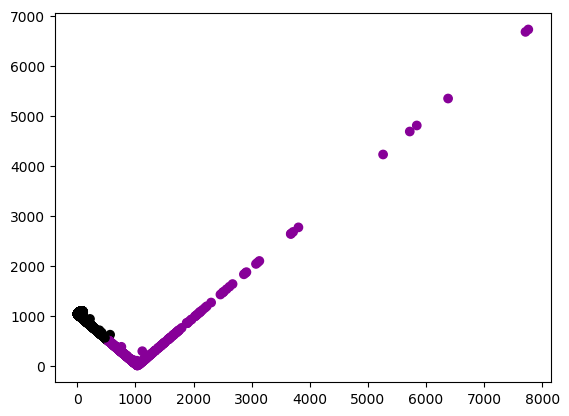

None

{'Intersection': 507, 'Num_Experts': 3238, 'Num_Experts_Predicted': 546}

{'Average Expert Stars': 3.7270807092875349,
 'Average User Stars': 3.5166145041821952,
 'Categories': ['Home Decor'],
 'MAE': 0.75847745266936883,
 'MSE': 0.9990640749274986,
 'Number of Businesses': 1452,
 'Number of Businesses with Experts': 635}

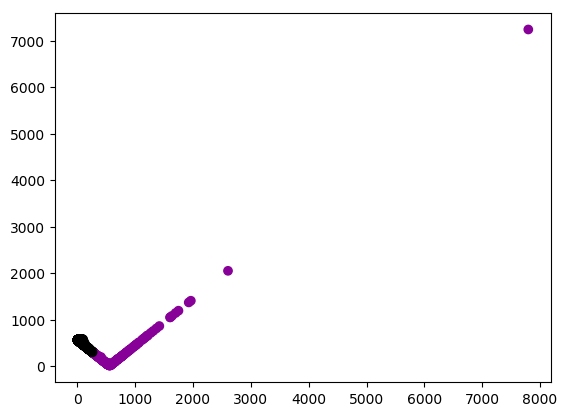

None

{'Intersection': 305, 'Num_Experts': 1133, 'Num_Experts_Predicted': 338}

{'Average Expert Stars': 4.1870561282932419,
 'Average User Stars': 4.1023526435900459,
 'Categories': ['Cosmetic Dentists'],
 'MAE': 0.86742238591860565,
 'MSE': 1.5010960293316182,
 'Number of Businesses': 1437,
 'Number of Businesses with Experts': 291}

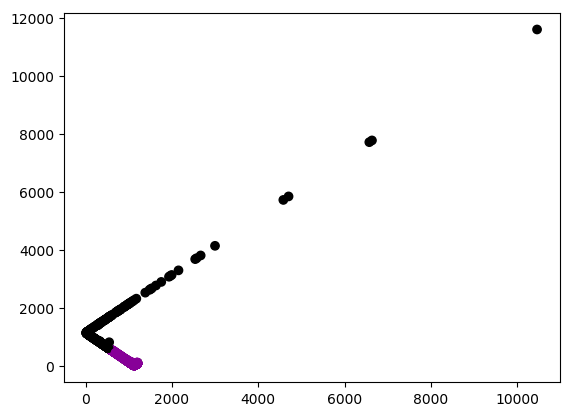

None

{'Intersection': 2464, 'Num_Experts': 2902, 'Num_Experts_Predicted': 13891}

{'Average Expert Stars': 2.9849749094970703,
 'Average User Stars': 3.3410026514079818,
 'Categories': ['Drugstores'],
 'MAE': 0.8185717014778342,
 'MSE': 1.1149883515387236,
 'Number of Businesses': 1415,
 'Number of Businesses with Experts': 724}

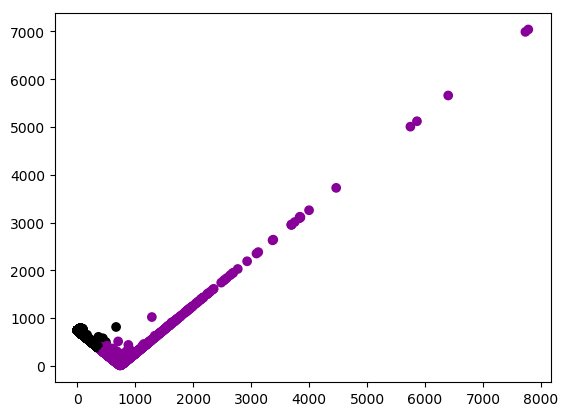

None

{'Intersection': 1932, 'Num_Experts': 10830, 'Num_Experts_Predicted': 2114}

{'Average Expert Stars': 3.4424777445157013,
 'Average User Stars': 3.5296274995372139,
 'Categories': ['Barbeque'],
 'MAE': 0.58038106241241127,
 'MSE': 0.61747662124907587,
 'Number of Businesses': 1413,
 'Number of Businesses with Experts': 982}

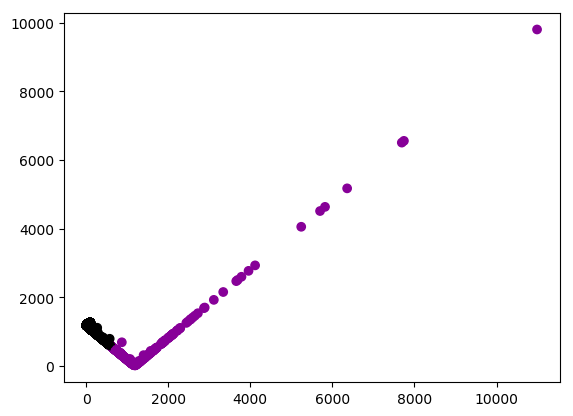

None

{'Intersection': 443, 'Num_Experts': 3756, 'Num_Experts_Predicted': 476}

{'Average Expert Stars': 3.2957429573116657,
 'Average User Stars': 3.0964534901759144,
 'Categories': ['Department Stores'],
 'MAE': 0.69505066977761298,
 'MSE': 0.83137703858069567,
 'Number of Businesses': 1395,
 'Number of Businesses with Experts': 874}

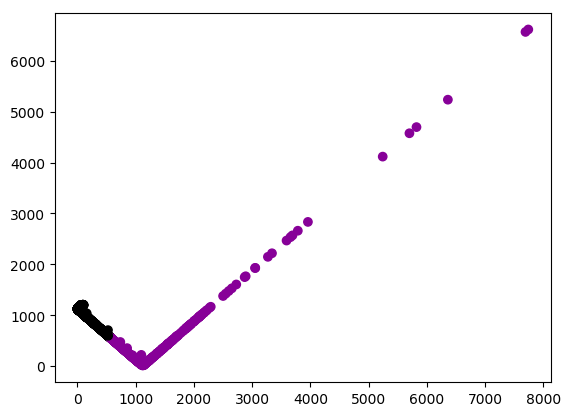

None

{'Intersection': 494, 'Num_Experts': 3180, 'Num_Experts_Predicted': 537}

{'Average Expert Stars': 3.5918322348214904,
 'Average User Stars': 3.4143723726600395,
 'Categories': ["Men's Clothing"],
 'MAE': 0.76442569585920994,
 'MSE': 0.98569845296649383,
 'Number of Businesses': 1388,
 'Number of Businesses with Experts': 728}

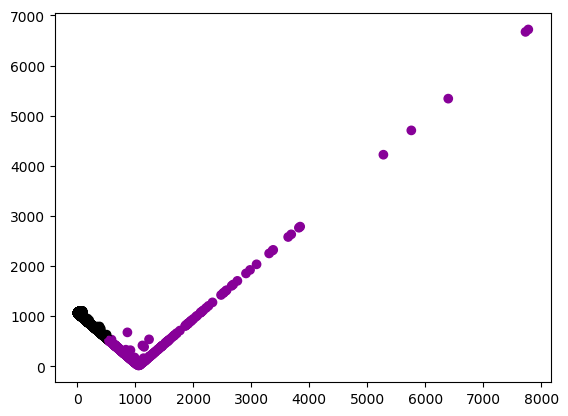

None

{'Intersection': 460, 'Num_Experts': 5030, 'Num_Experts_Predicted': 502}

{'Average Expert Stars': 3.5131113518372796,
 'Average User Stars': 3.4766683559451903,
 'Categories': ['Canadian (New)'],
 'MAE': 0.54043089599614047,
 'MSE': 0.51562977302336521,
 'Number of Businesses': 1357,
 'Number of Businesses with Experts': 749}

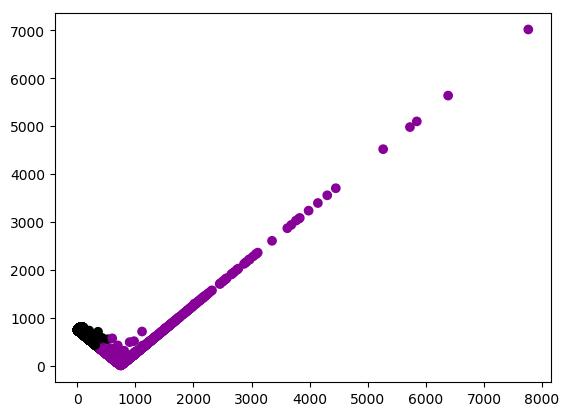

None

{'Intersection': 2863, 'Num_Experts': 14440, 'Num_Experts_Predicted': 3078}

{'Average Expert Stars': 3.578705196160942,
 'Average User Stars': 3.5549811116351107,
 'Categories': ['Lounges'],
 'MAE': 0.53386711977177448,
 'MSE': 0.5604215922909952,
 'Number of Businesses': 1346,
 'Number of Businesses with Experts': 968}

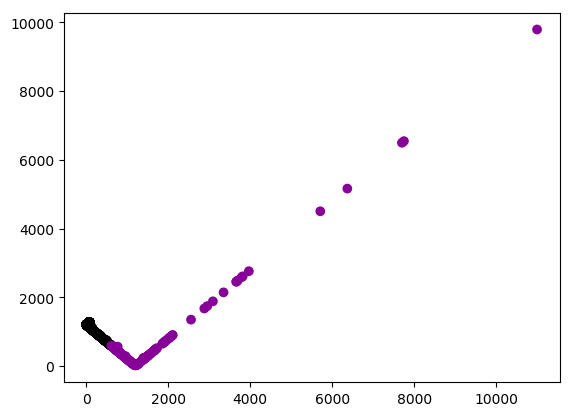

None

{'Intersection': 250, 'Num_Experts': 2538, 'Num_Experts_Predicted': 274}

{'Average Expert Stars': 3.8846355913257304,
 'Average User Stars': 3.7998844686224675,
 'Categories': ['Arts & Crafts'],
 'MAE': 0.65996724332020262,
 'MSE': 0.80012939003326455,
 'Number of Businesses': 1336,
 'Number of Businesses with Experts': 568}

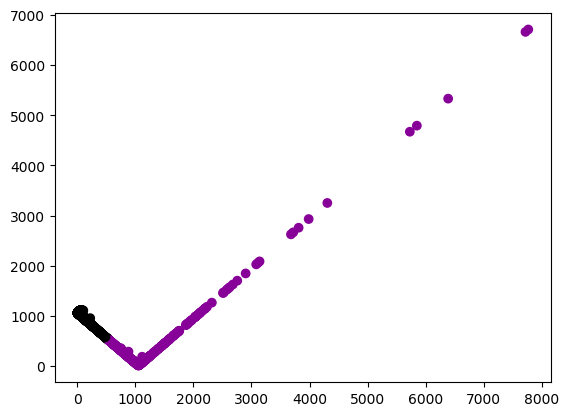

None

{'Intersection': 486, 'Num_Experts': 2427, 'Num_Experts_Predicted': 536}

{'Average Expert Stars': 3.9637492375894445,
 'Average User Stars': 3.8343938410326062,
 'Categories': ['Jewelry'],
 'MAE': 0.75560550658037606,
 'MSE': 1.085731739207473,
 'Number of Businesses': 1323,
 'Number of Businesses with Experts': 485}

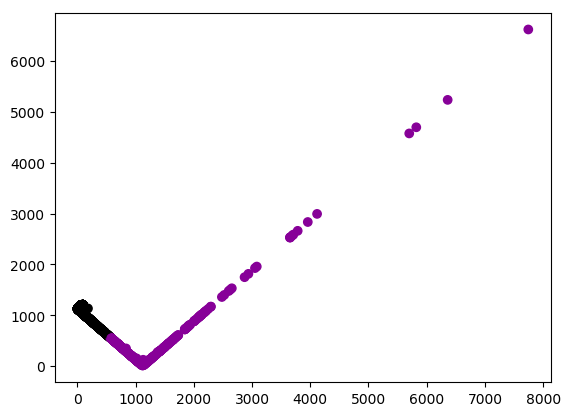

None

{'Intersection': 453, 'Num_Experts': 2717, 'Num_Experts_Predicted': 496}

{'Average Expert Stars': 3.4857993246142649,
 'Average User Stars': 3.2135779849898145,
 'Categories': ['Convenience Stores'],
 'MAE': 0.82352625877144037,
 'MSE': 1.1343729379698404,
 'Number of Businesses': 1322,
 'Number of Businesses with Experts': 675}

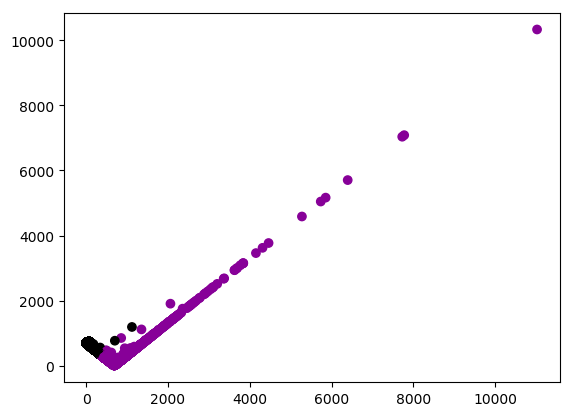

None

{'Intersection': 3620, 'Num_Experts': 17374, 'Num_Experts_Predicted': 3997}

{'Average Expert Stars': 3.5580925631807649,
 'Average User Stars': 3.4906298493455417,
 'Categories': ['Steakhouses'],
 'MAE': 0.49299829305941079,
 'MSE': 0.45656275481963599,
 'Number of Businesses': 1311,
 'Number of Businesses with Experts': 1013}

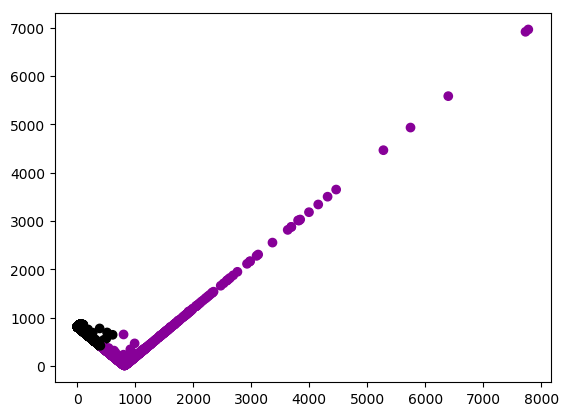

None

{'Intersection': 1409, 'Num_Experts': 9743, 'Num_Experts_Predicted': 1537}

{'Average Expert Stars': 3.4070665058233507,
 'Average User Stars': 3.6027580972748745,
 'Categories': ['Thai'],
 'MAE': 0.56124416227583274,
 'MSE': 0.56889732161850792,
 'Number of Businesses': 1291,
 'Number of Businesses with Experts': 855}

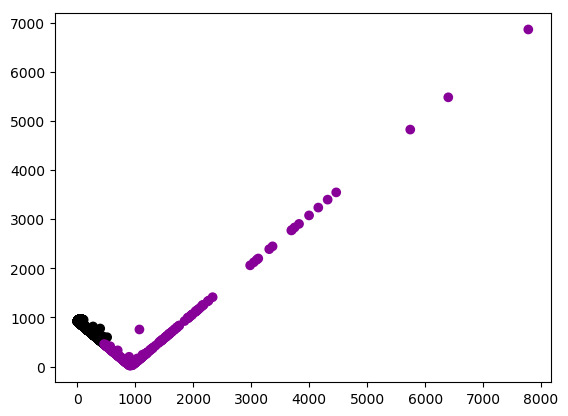

None

{'Intersection': 575, 'Num_Experts': 5328, 'Num_Experts_Predicted': 629}

{'Average Expert Stars': 3.5708419892988732,
 'Average User Stars': 3.6544344800460271,
 'Categories': ['Indian'],
 'MAE': 0.5801265507404979,
 'MSE': 0.59613535830615816,
 'Number of Businesses': 1289,
 'Number of Businesses with Experts': 661}

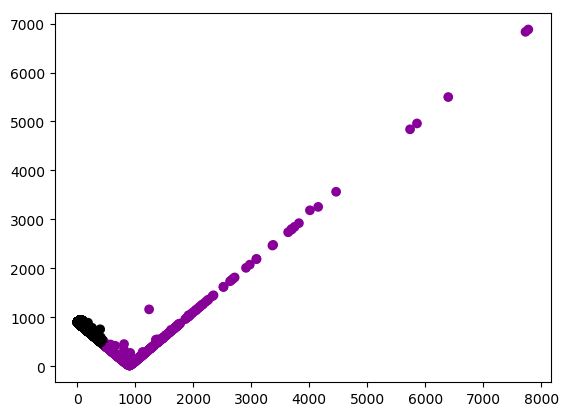

None

{'Intersection': 850, 'Num_Experts': 6579, 'Num_Experts_Predicted': 919}

{'Average Expert Stars': 3.7238893011302707,
 'Average User Stars': 3.7828695175308122,
 'Categories': ['Juice Bars & Smoothies'],
 'MAE': 0.64247173468402008,
 'MSE': 0.75444252851787963,
 'Number of Businesses': 1203,
 'Number of Businesses with Experts': 736}

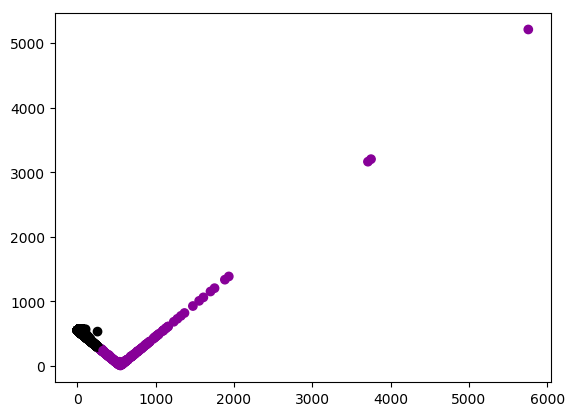

None

{'Intersection': 354, 'Num_Experts': 1612, 'Num_Experts_Predicted': 395}

{'Average Expert Stars': 4.0922936876158271,
 'Average User Stars': 4.0312356967094605,
 'Categories': ['Eyelash Service'],
 'MAE': 0.76424697912028206,
 'MSE': 1.0828606221043673,
 'Number of Businesses': 1185,
 'Number of Businesses with Experts': 303}

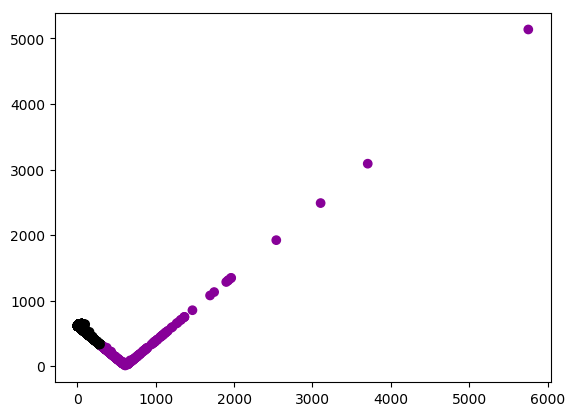

None

{'Intersection': 318, 'Num_Experts': 1358, 'Num_Experts_Predicted': 352}

{'Average Expert Stars': 4.1314186663160424,
 'Average User Stars': 4.1727151996891712,
 'Categories': ['Massage Therapy'],
 'MAE': 0.63146611699918365,
 'MSE': 0.77638946932028086,
 'Number of Businesses': 1163,
 'Number of Businesses with Experts': 265}

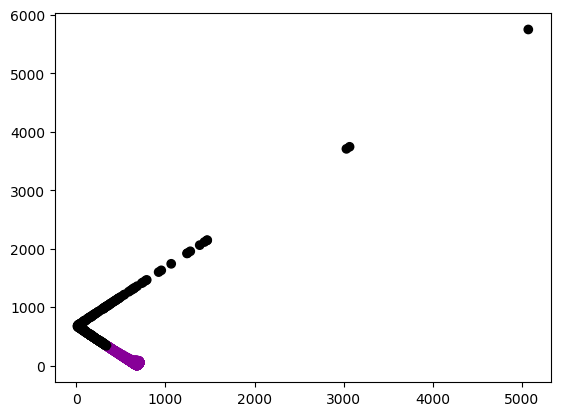

None

{'Intersection': 1087, 'Num_Experts': 1412, 'Num_Experts_Predicted': 15170}

{'Average Expert Stars': 3.1000570481997611,
 'Average User Stars': 3.6906235378306222,
 'Categories': ['Medical Centers'],
 'MAE': 1.084203512114837,
 'MSE': 1.8694819582989726,
 'Number of Businesses': 1163,
 'Number of Businesses with Experts': 367}

CPU times: user 5h 50min 20s, sys: 6min 57s, total: 5h 57min 18s
Wall time: 6h 6min 45s


In [17]:
%%time
EVALUATION = evaluate_categories(businessReviews, bus_rev_users, top_cats[0:100], False)

In [18]:
EVALUATION

,Average Expert Stars,Average User Stars,Categories,MAE,MSE,Number of Businesses,Number of Businesses with Experts
0,3.46208,3.47663,[Restaurants],0.598281,0.684942,51613,39058
0,3.71228,3.53921,[Shopping],0.785871,1.10689,24595,12018
0,3.69149,3.66542,[Food],0.621124,0.727511,23014,16759
0,3.77244,3.86773,[Beauty & Spas],0.796088,1.14579,15139,3798
0,3.73868,3.46193,[Home Services],0.981016,1.75491,13202,1939
0,3.94853,3.61554,[Health & Medical],0.959586,1.62622,12033,2595
0,3.52032,3.5251,[Nightlife],0.529242,0.553824,11364,8664
0,3.51867,3.52276,[Bars],0.517152,0.530951,9868,7610
0,3.65172,3.39708,[Automotive],0.941832,1.56356,9476,2619
0,3.86047,3.58398,[Local Services],0.856467,1.36165,9343,1965


In [19]:
out = EVALUATION.to_json(orient='records', lines=True)

In [20]:
with open('../evaluation/category_evaluation.txt', 'w') as f:
    f.write(out)